In [2]:
import torch
import numpy as np
import pandas as pd
import utils
import preprocess
import utils
import data

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
model_dir = '../model/{}.model'.format(record_pattern)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

model = torch.load(model_dir).to(device)
model.eval()

leiden_wgt = torch.from_numpy(np.load('../visualization/{}.leiden.npy'.format(record_pattern))).to(device)
prediction = torch.from_numpy(np.load('../prediction/predicted_matrix_{}.npy'.format(record_pattern))).to(device, dtype=torch.float)

In [3]:
def sc_projection(chromatin_profile_preds, clustervfeat):
    return np.dot(chromatin_profile_preds, clustervfeat.T)

def single_nucl_mutation(seq):
    '''
    Get single nucl mutation along given sequence and return encoded tensor
    '''
    db = ['A','T','C','G']

    seqlist = [seq]
    for i,nuc in enumerate(seq):
        for alt in db:
            if alt != nuc:
                alt_seq = seq[0:i]+alt+seq[i+1:]
                seqlist.append(alt_seq)

    alt_pre = preprocess.NucPreprocess(seqlist)
    X_alt = alt_pre.onehot_for_nuc()

    return X_alt

def single_nucl_mutation_at_middle(seqlist):
    '''
    Get single nucl mutation along given sequence at center and return encoded tensor
    '''
    db = ['A','T','C','G']

    mut_seqlist = []
    for seq in seqlist:
        mid_ind = int(len(seq)/2-1)
        for alt in db:
            if alt != seq[mid_ind]:
                alt_seq = seq[0:mid_ind]+alt+seq[mid_ind+1:]
                mut_seqlist.append(alt_seq)

    X_ref = preprocess.NucPreprocess(seqlist).onehot_for_nuc()
    X_alt = preprocess.NucPreprocess(mut_seqlist).onehot_for_nuc()

    return X_ref, X_alt

def get_nearest(k, vec, mat, cluster_vec):
    # 计算向量与目标矩阵中所有向量之间的欧氏距离
    distances = torch.norm(mat - vec, dim=1)
    
    # 找到距离最近的几个向量的索引
    nearest_indices = torch.argsort(distances)[:k]
    
    # 获取距离最近的几个向量
    nearest_vectors = cluster_vec[nearest_indices]

    return nearest_vectors

## Find changed cluster

In [9]:
import glob
import numpy as np
import pandas as pd
import re
import os
from tqdm import tqdm

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
result_path = '../variation/ricevarmap/prediction'

def sc_projection(chromatin_profile_preds, clustervfeat):
    return np.dot(chromatin_profile_preds, clustervfeat.T)

ordered_profiles = np.load('../prediction/{}.cluster_ordered_profiles.npy'.format(record_pattern))

file_list = ['{}/{:02d}.fa.ref.npy'.format(result_path, i) for i in range(0,len(os.listdir(result_path))//2)]
tnref = []
tnalt = []

for f in tqdm(file_list):
    ref = np.load(f)
    
    tnref.append(ref)

    alt = np.load(f.replace('ref','alt'))
  
    tnalt.append(alt)

tnref = np.vstack(tnref)
tnalt = np.vstack(tnalt)

tvcfs = pd.read_csv('../variation/ricevarmap/rice4k_geno.vcf_filtered_clustered.bed', header=None, sep="\t")

100%|██████████| 48/48 [10:20<00:00, 12.94s/it]


In [10]:
tnref = np.vstack(tnref)
tnalt = np.vstack(tnalt)

aa=tnalt-tnref

In [12]:
top_ind = aa.sum(axis=1).argsort()[-100000:]
top_tnref = torch.from_numpy(tnref[top_ind]).to(device, dtype=torch.float)
top_tnalt = torch.from_numpy(tnalt[top_ind]).to(device, dtype=torch.float)

In [25]:
from collections import Counter

clu_diff_ind = []
ref_not_match = 0
trans_ind = []

for i, ind in enumerate(tqdm(top_ind)):
    ref_cluster = tvcfs.iloc[ind][6]
    ref_k20 = get_nearest(20, top_tnref[i], prediction, leiden_wgt)
    ref_clu_count = Counter(ref_k20)
    cal_ref_clu = 'cluster'+str(int(sorted([ (k,ref_clu_count[k]) for k in ref_clu_count ], key=lambda x:x[1])[-1][0]))
    if ref_cluster == cal_ref_clu:
        alt_k20 = get_nearest(20, top_tnalt[i], prediction, leiden_wgt)
        alt_clu_count = Counter(alt_k20)
        cal_alt_clu = 'cluster'+str(int(sorted([ (k,alt_clu_count[k]) for k in alt_clu_count ], key=lambda x:x[1])[-1][0]))
        if cal_alt_clu != ref_cluster:
            trans_ind.append(top_ind)
            if cal_alt_clu == 'cluster0' or cal_alt_clu == 'cluster14':
                clu_diff_ind.append(ind)
        
    else:
        ref_not_match+=1
clu_diff_result = tvcfs.iloc[clu_diff_ind]
print("Not match: {}, ratio: {}".format(ref_not_match, ref_not_match/50000))
print("Trans cluster: {}".format(len(trans_ind)))
np.save('../variation/diff_ind_clu_ricevarmap.npy',np.array(clu_diff_ind))

100%|██████████| 100000/100000 [20:07<00:00, 82.79it/s]

Not match: 68500, ratio: 1.37
Trans cluster: 5506


In [56]:
[definition[rec] for rec in clu_diff_result[6]]

['HET1 Heterochromatin',
 'HHETP2 Hybrid Heterochromatin',
 'TN1 Transcription',
 'TN2 Transcription',
 'HET11 Heterochromatin',
 'B2 Bivalent',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'HHETP2 Hybrid Heterochromatin',
 'TN1 Transcription',
 'TN1 Transcription',
 'B2 Bivalent',
 'TN2 Transcription',
 'TN2 Transcription',
 'L1 Low signal',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'B2 Bivalent',
 'TN1 Transcription',
 'B2 Bivalent',
 'HHETP1 Hybrid Heterochromatin',
 'E1 Enhancer',
 'HHETP2 Hybrid Heterochromatin',
 'B2 Bivalent',
 'HET12 Heterochromatin',
 'TN1 Transcription',
 'TN2 Transcription',
 'HHETP2 Hybrid Heterochromatin',
 'HHETP2 Hybrid Heterochromatin',
 'TN1 Transcription',
 'HHETP2 Hybrid Heterochromatin',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'TN1 Transcription',
 'HHETP2 Hybrid Heterochromatin',
 'TN2 Transcription',
 'HET1 He

In [3]:
tvcfs = pd.read_csv('../variation/ricevarmap/rice4k_geno.vcf_filtered_clustered.bed', header=None, sep="\t")

clu_diff_ind = np.load('../variation/diff_ind_clu_ricevarmap.npy')
clu_diff_result = tvcfs.iloc[clu_diff_ind]

In [11]:
clu_diff_result.to_csv('../variation/ricevarmap/QTR/clu_diff.bed',sep="\t",header=None, index=False) 

In [4]:
cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
definition = cluster_def['definition']
definition

{'cluster17': 'RP1 Repressed Polycomb',
 'cluster8': 'RP2 Repressed Polycomb',
 'cluster19': 'RP3 Repressed Polycomb',
 'cluster6': 'RP4 Repressed Polycomb',
 'cluster31': 'BT1 Bivalent TSS',
 'cluster4': 'BT2 Bivalent TSS',
 'cluster18': 'HET1 Heterochromatin',
 'cluster25': 'HET2 Heterochromatin',
 'cluster27': 'HET3 Heterochromatin',
 'cluster26': 'HET4 Heterochromatin',
 'cluster15': 'HET5 Heterochromatin',
 'cluster20': 'HET6 Heterochromatin',
 'cluster21': 'HET7 Heterochromatin',
 'cluster28': 'HET8 Heterochromatin',
 'cluster30': 'HET9 Heterochromatin',
 'cluster9': 'HET10 Heterochromatin',
 'cluster12': 'HET11 Heterochromatin',
 'cluster24': 'HET12 Heterochromatin',
 'cluster32': 'HHETP1 Hybrid Heterochromatin',
 'cluster2': 'HHETP2 Hybrid Heterochromatin',
 'cluster11': 'B1 Bivalent',
 'cluster1': 'B2 Bivalent',
 'cluster29': 'TN1 Transcription',
 'cluster3': 'TN2 Transcription',
 'cluster7': 'TN3 Transcription',
 'cluster22': 'E2 Enhancer',
 'cluster23': 'E3 Enhancer',
 'clus

In [6]:
for i in clu_diff_result[clu_diff_result[0]==1].sort_values(2).values:
    print(i)

[1 66735 67759 'A' 'G' 0.1905508284818629 'cluster29' 209]
[1 66864 67888 'A' 'T' 0.0531104528142192 'cluster29' 80]
[1 802238 803262 'A' 'G' 0.7208983840043823 'cluster18' 194]
[1 860303 861327 'C' 'T' 0.2425968109339407 'cluster3' 241]
[1 1117522 1118546 'G' 'T' 0.1641253706056755 'cluster4' 46]
[1 1318596 1319620 'T' 'G' 0.2205444978265843 'cluster3' 188]
[1 2399663 2400687 'C' 'G' 0.0093085106382978 'cluster29' 209]
[1 2667801 2668825 'T' 'C' 0.001481168006771 'cluster1' 103]
[1 5590101 5591125 'A' 'G' 0.4059219380888291 'cluster4' 43]
[1 6646160 6647184 'A' 'T' 0.1673513513513513 'cluster2' 240]
[1 7954090 7955114 'C' 'A' 0.0011436413540713 'cluster12' 214]
[1 8533457 8534481 'A' 'G' 0.0015941698929628 'cluster1' 175]
[1 8621382 8622406 'T' 'C' 0.0137189469781238 'cluster18' 58]
[1 9452484 9453508 'C' 'A' 0.043377063055438 'cluster3' 188]
[1 9971803 9972827 'C' 'G' 0.0943396226415094 'cluster4' 37]
[1 10028727 10029751 'C' 'T' 0.0042372881355932 'cluster29' 201]
[1 10028921 100299

In [182]:
tvcfs = pd.read_csv('../variation/ricevarmap/rice4k_geno.vcf_filtered_clustered.bed', header=None, sep="\t")

In [247]:
tvcfs[tvcfs[1]+512==16410299]

0         1         2  3  4         5          6    7
546661   1  16409787  16410811  G  A  0.008675  cluster20  197
7554688  7  16409787  16410811  G  T  0.008770   cluster9  197
9891974  9  16409787  16410811  C  G  0.083369   cluster4  197

In [186]:
get_nearest(10, tnref[355798], pred_mat, leiden_wgt)

array([0, 0, 0, 0, 2, 0, 3, 0, 0, 0])

In [317]:
from collections import Counter

clu_count = Counter(get_nearest(10, tnalt[355798], pred_mat, leiden_wgt))

In [321]:
sorted([ (k,clu_count[k]) for k in clu_count ], key=lambda x:x[1])[-1][0]

2

In [204]:
chrom=1
center=12291252
name="vg{:02d}{:08d}".format(chrom, center)

!echo -e "$chrom\t$center" | awk -vOFS="\t" '{print 1,2-512,2+512}' 

1	-510	514


## Smooth full-mut

In [5]:
leiden_wgt = leiden_wgt.to(cpu).numpy()

In [58]:
cluster_def

{'definition': {'cluster17': 'RP1 Repressed Polycomb',
  'cluster8': 'RP2 Repressed Polycomb',
  'cluster19': 'RP3 Repressed Polycomb',
  'cluster6': 'RP4 Repressed Polycomb',
  'cluster31': 'BT1 Bivalent TSS',
  'cluster4': 'BT2 Bivalent TSS',
  'cluster18': 'HET1 Heterochromatin',
  'cluster25': 'HET2 Heterochromatin',
  'cluster27': 'HET3 Heterochromatin',
  'cluster26': 'HET4 Heterochromatin',
  'cluster15': 'HET5 Heterochromatin',
  'cluster20': 'HET6 Heterochromatin',
  'cluster21': 'HET7 Heterochromatin',
  'cluster28': 'HET8 Heterochromatin',
  'cluster30': 'HET9 Heterochromatin',
  'cluster9': 'HET10 Heterochromatin',
  'cluster12': 'HET11 Heterochromatin',
  'cluster24': 'HET12 Heterochromatin',
  'cluster32': 'HHETP1 Hybrid Heterochromatin',
  'cluster2': 'HHETP2 Hybrid Heterochromatin',
  'cluster11': 'B1 Bivalent',
  'cluster1': 'B2 Bivalent',
  'cluster29': 'TN1 Transcription',
  'cluster3': 'TN2 Transcription',
  'cluster7': 'TN3 Transcription',
  'cluster22': 'E2 Enhanc

vg0916410299
Total seq: 3073, start: 16409787
Start prediction, total:  3073
0 0.0


//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

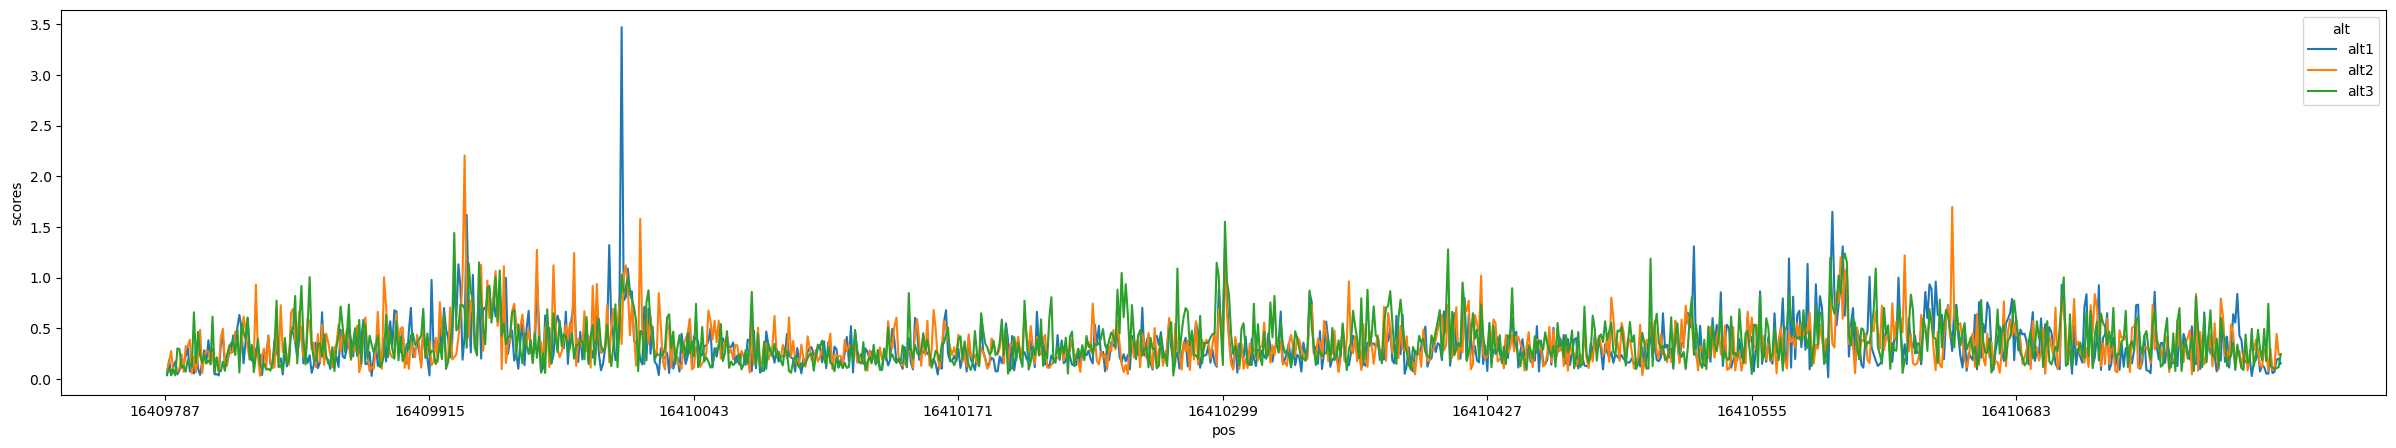

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

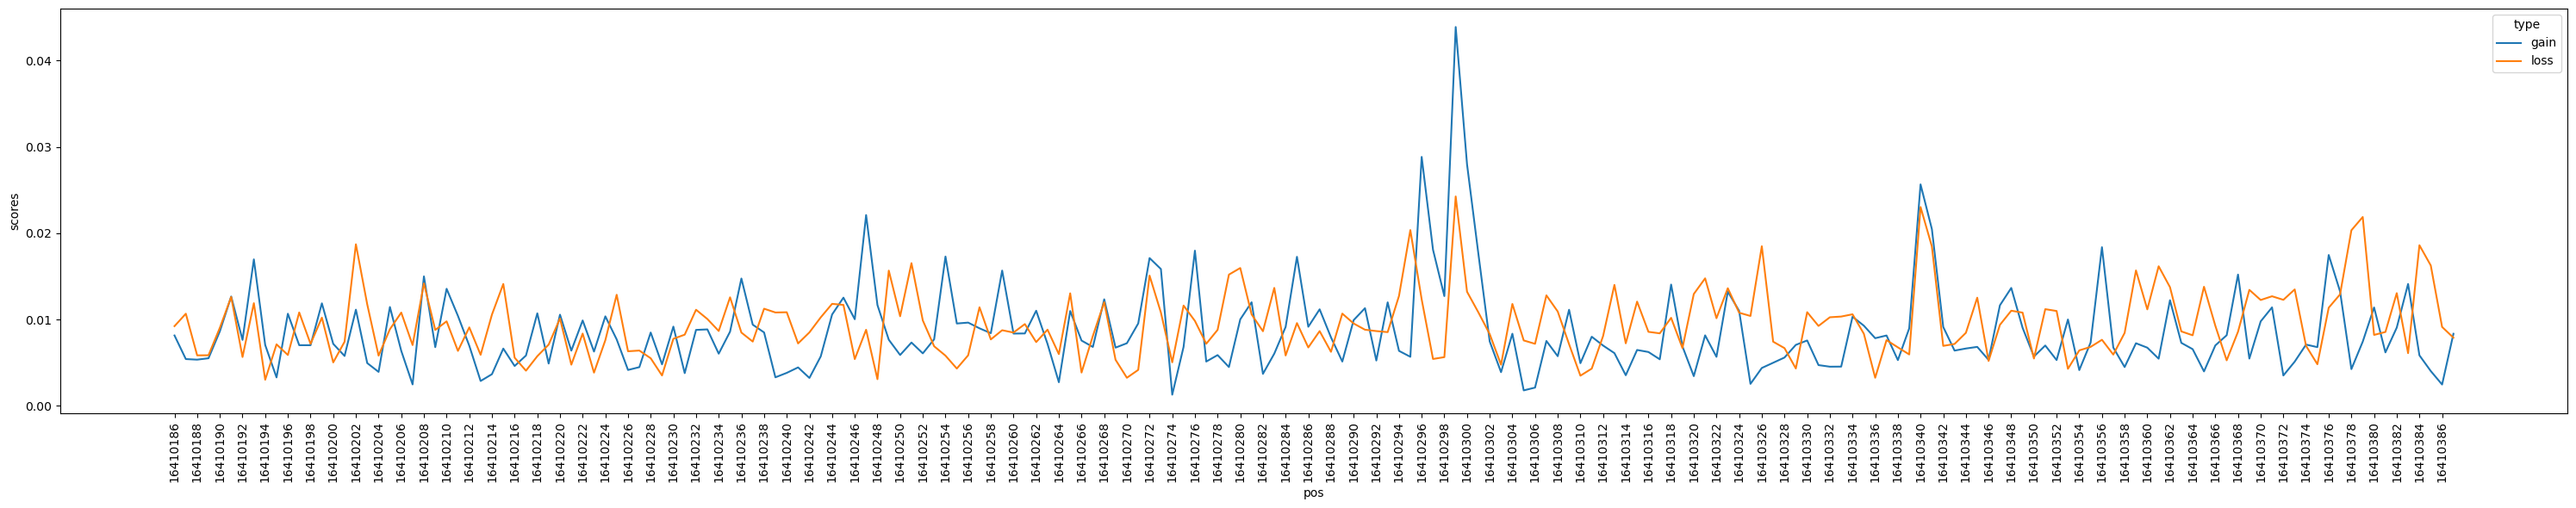

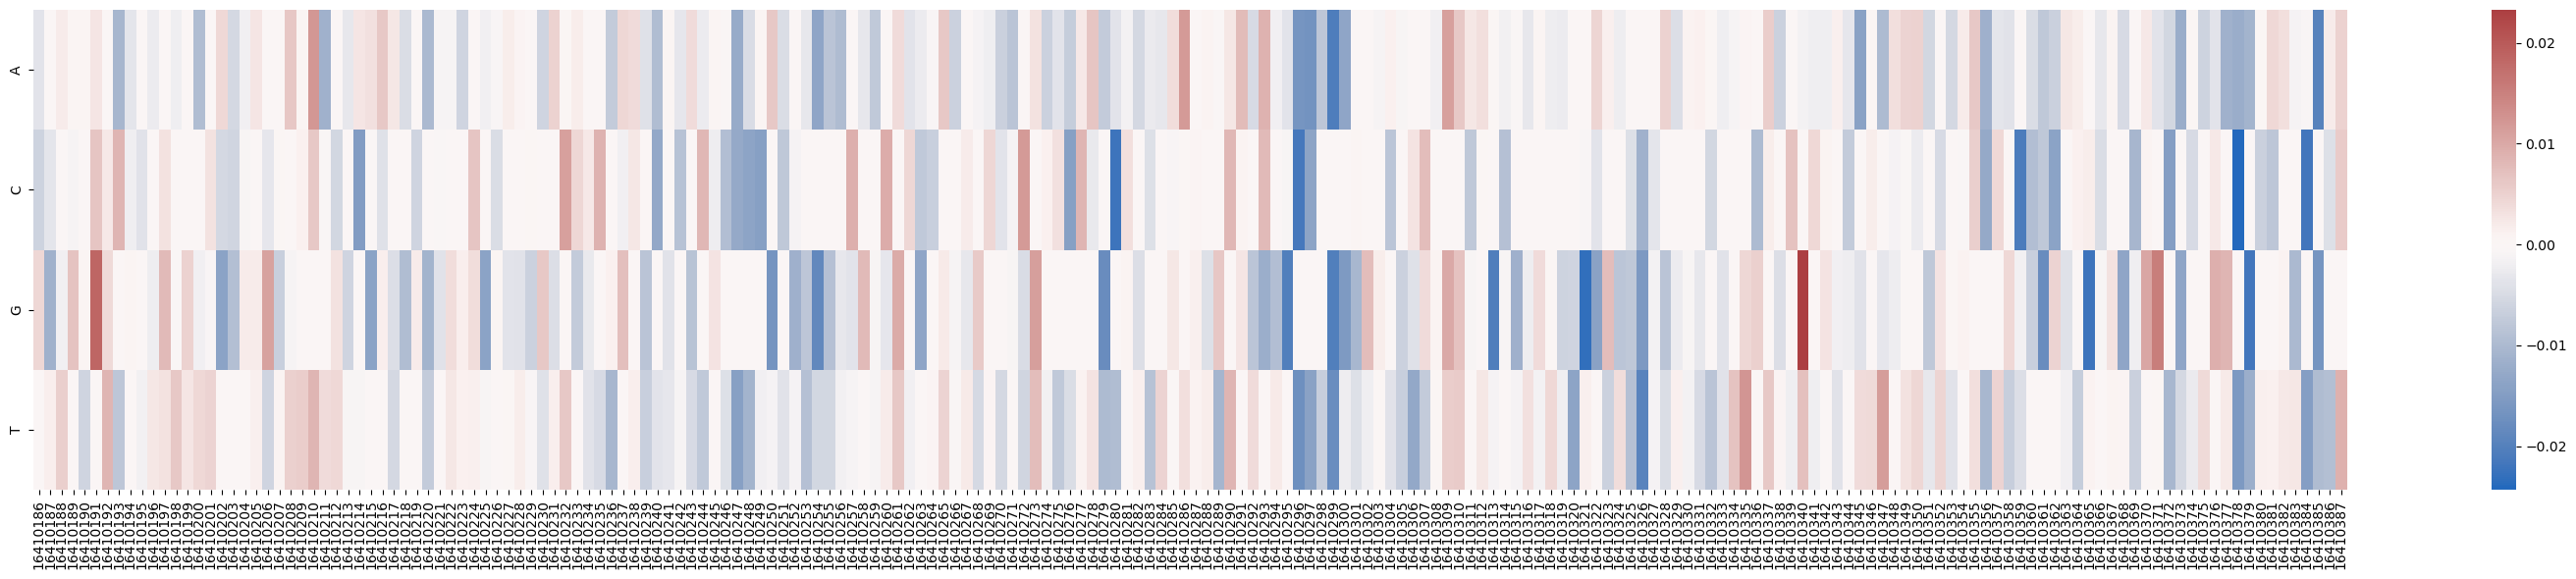

In [57]:
from os import environ
import torch
import numpy as np
import pandas as pd
import utils
import preprocess
import utils
import data


chrom=9
center=16410299


name="vg{:02d}{:08d}".format(chrom, center)
print(name)


environ['name']=name

with open('../variation/batch/{}.bed'.format(name), 'w+') as f:
    f.write('{}\t{}\t{}'.format(chrom, center-512, center+512))

!bedtools getfasta -fi ../genome/oryza_sativa.fa -bed ../variation/batch/$name.bed > ../variation/batch/$name.fa

mut_path = '../variation/batch/{}.fa'.format(name)
seqs = utils.load_data(mut_path)
start = center-512
X_alt = single_nucl_mutation(seqs[0])
print("Total seq: {}, start: {}".format(len(X_alt), start))

batch_size = 512

pre_dataset = data.NucDataset(x=X_alt, y=[0]*len(X_alt))
pre_loader = torch.utils.data.DataLoader(dataset=pre_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

total_pre = torch.tensor([[0]*n_feature],dtype=torch.float)

with torch.no_grad():
    print('Start prediction, total: ', len(X_alt))
    for i, (inputs, _) in enumerate(pre_loader):
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        try:
            total_pre = torch.concat((total_pre, outputs.to(cpu, dtype=torch.float)))
        except:
            total_pre = torch.concat((total_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))
        if i%100 == 0:
            print(i, i/len(pre_loader))

total_pre = total_pre[1:].numpy()

ordered_profiles = np.load('../prediction/{}.cluster_ordered_profiles.npy'.format(record_pattern))


total_pre_scores = sc_projection(total_pre, ordered_profiles)
source = total_pre_scores[0]
target = total_pre_scores[1:]
scores = target-source
scores = np.sum(np.abs(scores), axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))
plot_data = pd.DataFrame([ [rec, 'alt'+str(i%3+1) ]  for i, rec in enumerate(scores) ])
plot_data.columns = ['scores','alt']
plot_data['pos'] = plot_data.index//3+1

sns.lineplot(plot_data,x='pos', y='scores', hue='alt')
plt.xticks(range(0, 1024, 128), range(start, start+1024, 128))
plt.show()

cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
ordered_category = np.array([ cluster_def['definition']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['definition'] ])

asc_ind = {}
for i, rec in enumerate(ordered_category):
    if rec in asc_ind:
        asc_ind[rec].append(i)
    else:
        asc_ind[rec] = [i]

result = []
for rec in (target-source):
    tmp = {}
    for key in asc_ind:
        tmp[key] = rec[asc_ind[key]]
    result.append(tmp)

plot_data = []
for i, rec in enumerate(result):
    pos = i//3
    alt = i%3
    db = ['A','T','C','G']
    db.pop(db.index(seqs[0][pos]))
    for key in rec:
        tmp = {'pos': pos, 'alt': db[alt], 'scores': rec[key][0], 'category': key}
        plot_data.append(tmp)

pdata = pd.DataFrame(plot_data)

gain_class = ['TN3 Transcription','E2 Enhancer','E3 Enhancer','E4 Enhancer','E5 Enhancer','E6 Enhancer','HHETP2 Hybrid Heterochromatin']

total_cnum = len(cluster_def['definition'])
gain_cnum = len(gain_class)
loss_cnum = total_cnum - gain_cnum

gain_score = np.zeros(pdata['pos'].max()+1)
loss_score = np.zeros(pdata['pos'].max()+1)

for i in range(pdata['pos'].max()): 
    tmp_pos = pdata[pdata.category.isin(gain_class)].groupby('pos').get_group(i)
    tmp_neg = pdata[~pdata.category.isin(gain_class)].groupby('pos').get_group(i)
    gain_score[i] = (tmp_pos[tmp_pos.scores>=0].scores.sum()-tmp_neg[tmp_neg.scores<0].scores.sum())/(len(tmp_pos[tmp_pos.scores>=0])+len(tmp_neg[tmp_neg.scores<0]))
    loss_score[i] = (tmp_neg[tmp_neg.scores>=0].scores.sum()-tmp_pos[tmp_pos.scores<0].scores.sum())/(len(tmp_pos[tmp_pos.scores<0])+len(tmp_neg[tmp_neg.scores>=0]))

gain = pdata[pdata.category.isin(gain_class)].groupby('pos').sum()
gain['scores'] = gain_score
gain['type'] = 'gain'
gain['pos'] = gain.index 
loss = pdata[~pdata.category.isin(gain_class)].groupby('pos').sum()
loss['scores'] = loss_score
loss['type'] = 'loss'
loss['pos'] = loss.index

cate_sun_pdata = pd.concat([gain,loss])

fig = plt.figure(figsize=(30,6))
sns.lineplot(cate_sun_pdata.loc[cate_sun_pdata['pos'].isin(list(range(399,601)))], x='pos',y='scores', hue='type')
plt.xticks(range(399, 601, 2), labels=range(399+start, 601+start, 2), rotation=90)
plt.tight_layout()
plt.savefig('../figures/variation_{}.pdf'.format(name), dpi=300)
plt.show()



a=pdata[pdata.category.isin(gain_class)].groupby(['pos', 'alt']).sum()
b=pdata[~pdata.category.isin(gain_class)].groupby(['pos', 'alt']).sum()
a['scores'] = a['scores'].abs()/gain_cnum-b['scores'].abs()/loss_cnum

heatp_data = a
pos_ind = [ i[0] for i in heatp_data.index ]
alt_ind = [ i[1] for i in heatp_data.index ]
heatp_data['pos'] = pos_ind
heatp_data['alt'] = alt_ind
heatp_data.index = pos_ind

var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

values_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    values_result.append(np.insert(var_values[i], ref_ind, 0))
values_result = np.array(values_result)

fig = plt.figure(figsize=(30,6))
sns.heatmap(values_result[399:601,].T, cmap='vlag', center=0, xticklabels = range(399+start, 601+start), yticklabels=ref_db)
plt.tight_layout()
plt.savefig('../figures/variation_{}_heatmap.pdf'.format(name), dpi=300)
plt.show()

var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

logo_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    tmp_values = [0,0,0,0]
    tmp_values[ref_ind] = abs(np.sum(var_values[i]))
    logo_result.append(tmp_values)
logo_result = np.array(logo_result)
np.savetxt("../variation/batch/{}_logoValues.csv".format(name), logo_result[399:601,].T, delimiter=',')

In [20]:
pdata[pdata.category.isin(gain_class)]

pos alt    scores                       category
2          0   T  0.003546  HHETP2 Hybrid Heterochromatin
5          0   T  0.001691                    E6 Enhancer
7          0   T  0.003233              TN3 Transcription
10         0   T  0.001784                    E5 Enhancer
16         0   T  0.000656                    E4 Enhancer
...      ...  ..       ...                            ...
101350  1023   G  0.000728              TN3 Transcription
101353  1023   G  0.000246                    E5 Enhancer
101359  1023   G  0.000029                    E4 Enhancer
101365  1023   G  0.000478                    E2 Enhancer
101366  1023   G  0.000054                    E3 Enhancer

[21504 rows x 4 columns]

In [30]:
for i in range(pdata['pos'].max()): 
    tmp_pos = pdata[pdata.category.isin(gain_class)].groupby('pos').get_group(i)
    tmp_neg = pdata[~pdata.category.isin(gain_class)].groupby('pos').get_group(i)
    gain += tmp_pos[tmp_pos.scores>=0].scores.sum()+tmp_loss[tmp_loss.scores<0].scores.sum().abs()
    loss += tmp_pos[tmp_pos.scores<0].scores.sum().abs()+tmp_loss[tmp_loss.scores>0].scores.sum()

In [95]:
pos_eff = pdata[pdata.category.isin(['TN3 Transcription','E2 Enhancer','E3 Enhancer','E4 Enhancer','E5 Enhancer','E6 Enhancer','HHETP2 Hybrid Heterochromatin'])].groupby('pos').sum()
neg_eff = pdata[~pdata.category.isin(['TN3 Transcription','E2 Enhancer','E3 Enhancer','E4 Enhancer','E5 Enhancer','E6 Enhancer','HHETP2 Hybrid Heterochromatin'])].groupby('pos').sum()

gain = pdata[pdata.category.isin(['TN3 Transcription','E2 Enhancer','E3 Enhancer','E4 Enhancer','E5 Enhancer','E6 Enhancer','HHETP2 Hybrid Heterochromatin'])].groupby('pos').sum()


alt    scores  \
pos                                     
0     TTTTTTTCCCCCCCGGGGGGG  0.141914   
1     AAAAAAATTTTTTTGGGGGGG  0.004881   
2     AAAAAAATTTTTTTCCCCCCC -0.068442   
3     AAAAAAACCCCCCCGGGGGGG  0.285956   
4     AAAAAAATTTTTTTCCCCCCC -0.158125   
...                     ...       ...   
1019  AAAAAAACCCCCCCGGGGGGG  0.038577   
1020  TTTTTTTCCCCCCCGGGGGGG  0.011839   
1021  TTTTTTTCCCCCCCGGGGGGG  0.021149   
1022  TTTTTTTCCCCCCCGGGGGGG  0.008120   
1023  TTTTTTTCCCCCCCGGGGGGG -0.004605   

                                               category  
pos                                                      
0     HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
1     HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
2     HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
3     HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
4     HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
...                                                 ...  
1019  HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
1020  HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
1021  HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
1022  HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  
1023  HHETP2 Hybrid HeterochromatinE6 EnhancerTN3 Tr...  

[1024 rows x 3 columns]

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

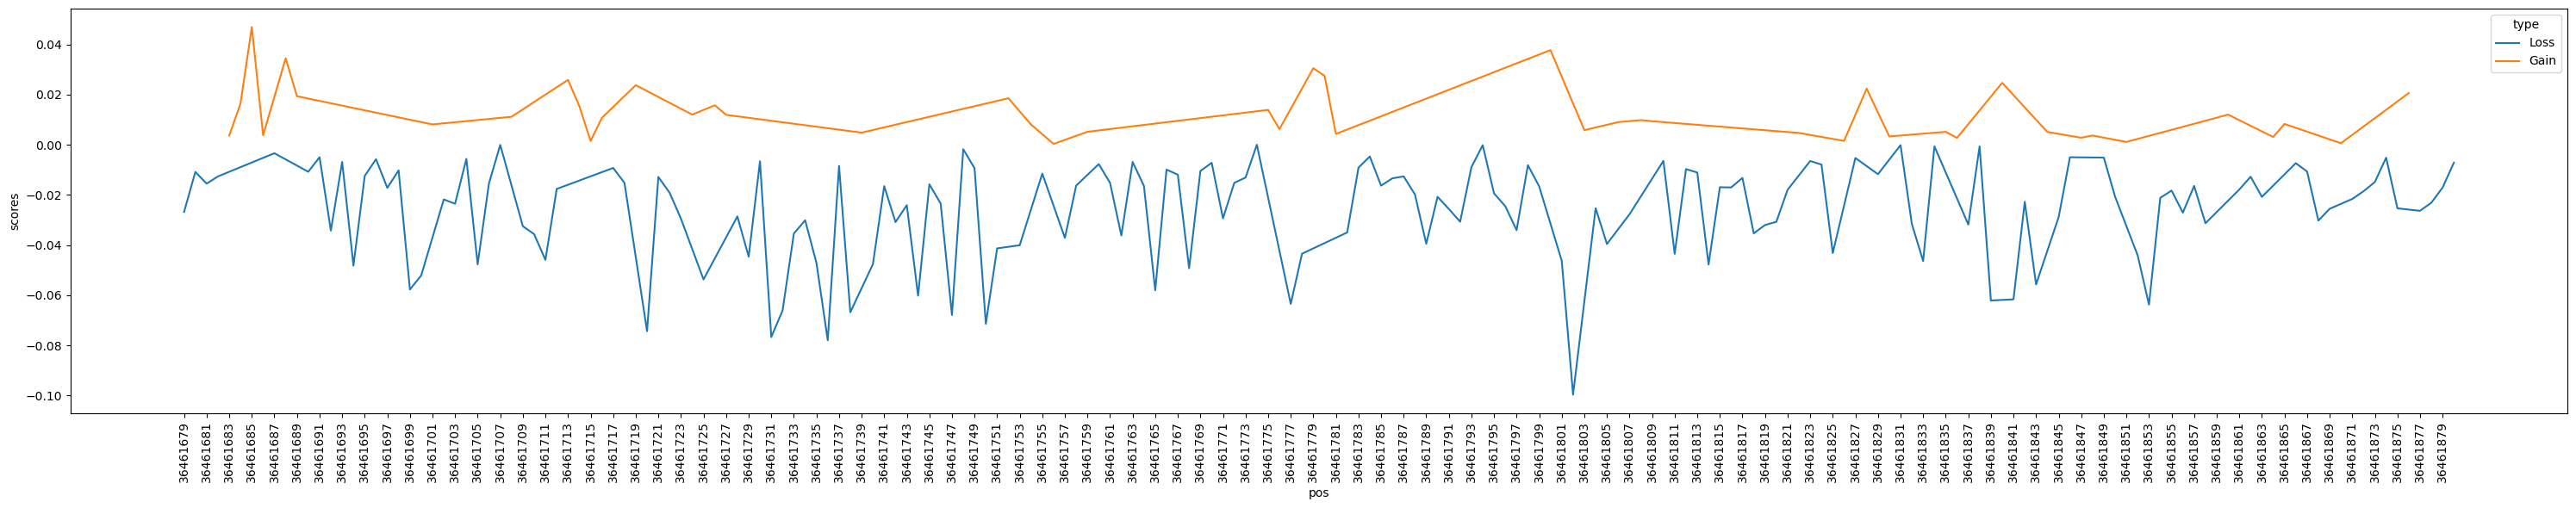

In [78]:
values_score = gain['scores'] - loss['scores']
type = np.array(['Loss']*len(values_score))
type[values_score > 0] = 'Gain'
pos = np.array(list(range(0,1024)))
cate_sun_pdata = pd.DataFrame({'pos':pos, 'type':type, 'scores':values_score})
cate_sun_pdata

fig = plt.figure(figsize=(30,6))
sns.lineplot(cate_sun_pdata.loc[cate_sun_pdata['pos'].isin(list(range(399,601)))], x='pos',y='scores', hue='type')
plt.xticks(range(399, 601, 2), labels=range(399+start, 601+start, 2), rotation=90)
plt.tight_layout()
plt.show()

In [38]:
pdata[pdata.category.isin(['Transcription','Enhancer','Hybrid Heterochromatin'])].groupby('pos').sum()

alt    scores                                           category
pos                                                                         
0     TTTCCCGGG  0.328801  Hybrid HeterochromatinTranscriptionEnhancerHyb...
1     AAATTTGGG -0.020655  Hybrid HeterochromatinTranscriptionEnhancerHyb...
2     AAATTTCCC -0.206212  Hybrid HeterochromatinTranscriptionEnhancerHyb...
3     AAACCCGGG  0.669096  Hybrid HeterochromatinTranscriptionEnhancerHyb...
4     AAATTTCCC -0.400616  Hybrid HeterochromatinTranscriptionEnhancerHyb...
...         ...       ...                                                ...
1019  AAACCCGGG  0.063557  Hybrid HeterochromatinTranscriptionEnhancerHyb...
1020  TTTCCCGGG  0.018892  Hybrid HeterochromatinTranscriptionEnhancerHyb...
1021  TTTCCCGGG  0.045217  Hybrid HeterochromatinTranscriptionEnhancerHyb...
1022  TTTCCCGGG  0.014143  Hybrid HeterochromatinTranscriptionEnhancerHyb...
1023  TTTCCCGGG -0.007637  Hybrid HeterochromatinTranscriptionEnhancerHyb...

[1024 rows x 3 columns]

In [25]:
pdata[pdata.category.isin(['Transcription','Enhancer','Hybrid Heterochromatin'])]
pdata[~pdata.category.isin(['Transcription','Enhancer','Hybrid Heterochromatin'])]

pos alt    scores            category
0         0   T  0.026005          Low signal
1         0   T  0.039818            Bivalent
4         0   T  0.009761        Bivalent TSS
6         0   T  0.087645  Repressed Polycomb
7         0   T  0.026052     Heterochromatin
...     ...  ..       ...                 ...
24568  1023   G  0.004915          Low signal
24569  1023   G  0.004099            Bivalent
24572  1023   G  0.005651        Bivalent TSS
24574  1023   G  0.010527  Repressed Polycomb
24575  1023   G  0.005690     Heterochromatin

[15360 rows x 4 columns]

In [31]:
mean_alt = total_pre[1:][511*3:511*3+3].mean(axis=0)
get_nearest(20, mean_alt, prediction, leiden_wgt)

array([3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 3, 3, 4, 3])

In [24]:
pdata

pos alt    scores                category
0         0   T  0.026005              Low signal
1         0   T  0.039818                Bivalent
2         0   T  0.005847  Hybrid Heterochromatin
3         0   T  0.015993           Transcription
4         0   T  0.009761            Bivalent TSS
...     ...  ..       ...                     ...
24571  1023   G  0.003901           Transcription
24572  1023   G  0.005651            Bivalent TSS
24573  1023   G  0.001878                Enhancer
24574  1023   G  0.010527      Repressed Polycomb
24575  1023   G  0.005690         Heterochromatin

[24576 rows x 4 columns]

## Single Mut

vg0100304715
Start prediction, total:  4096
1 0.125
2 0.25
3 0.375
4 0.5
5 0.625
6 0.75
7 0.875
8 1.0


//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

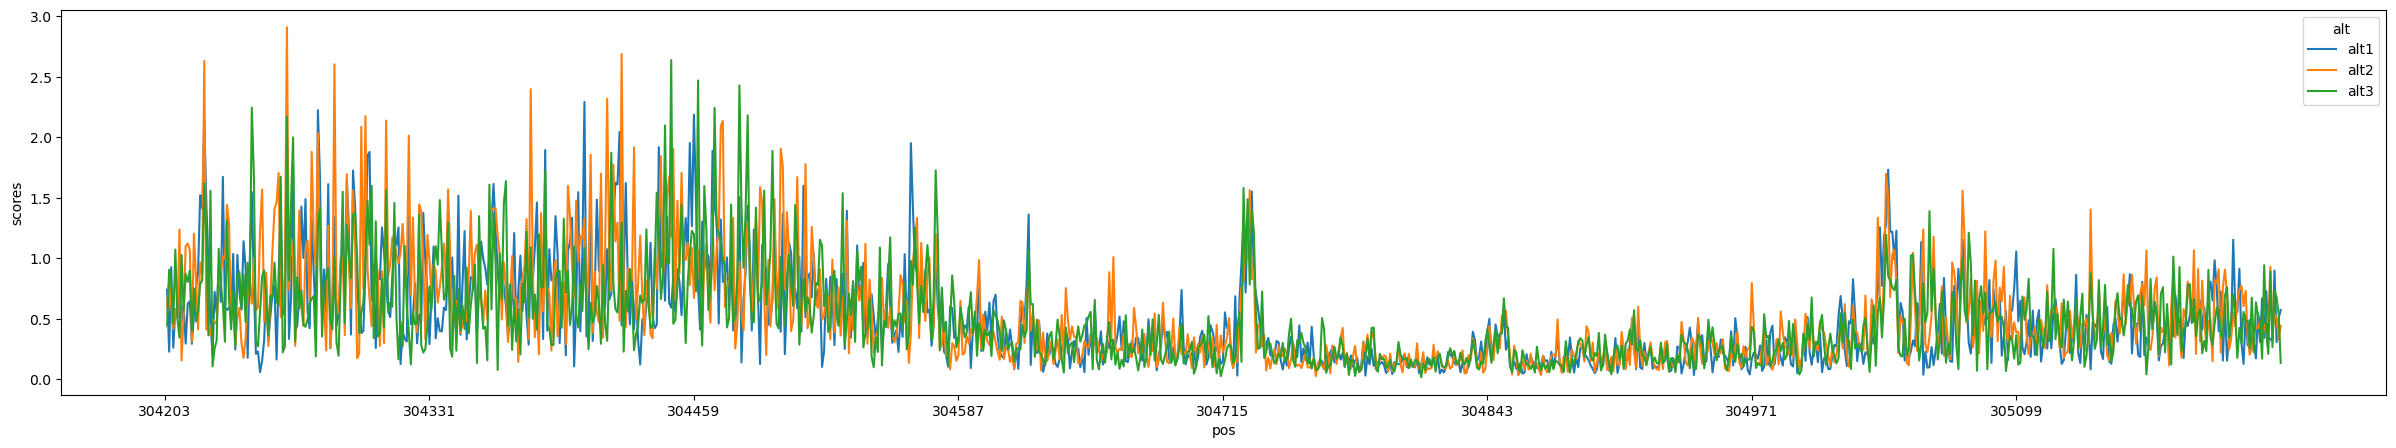

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

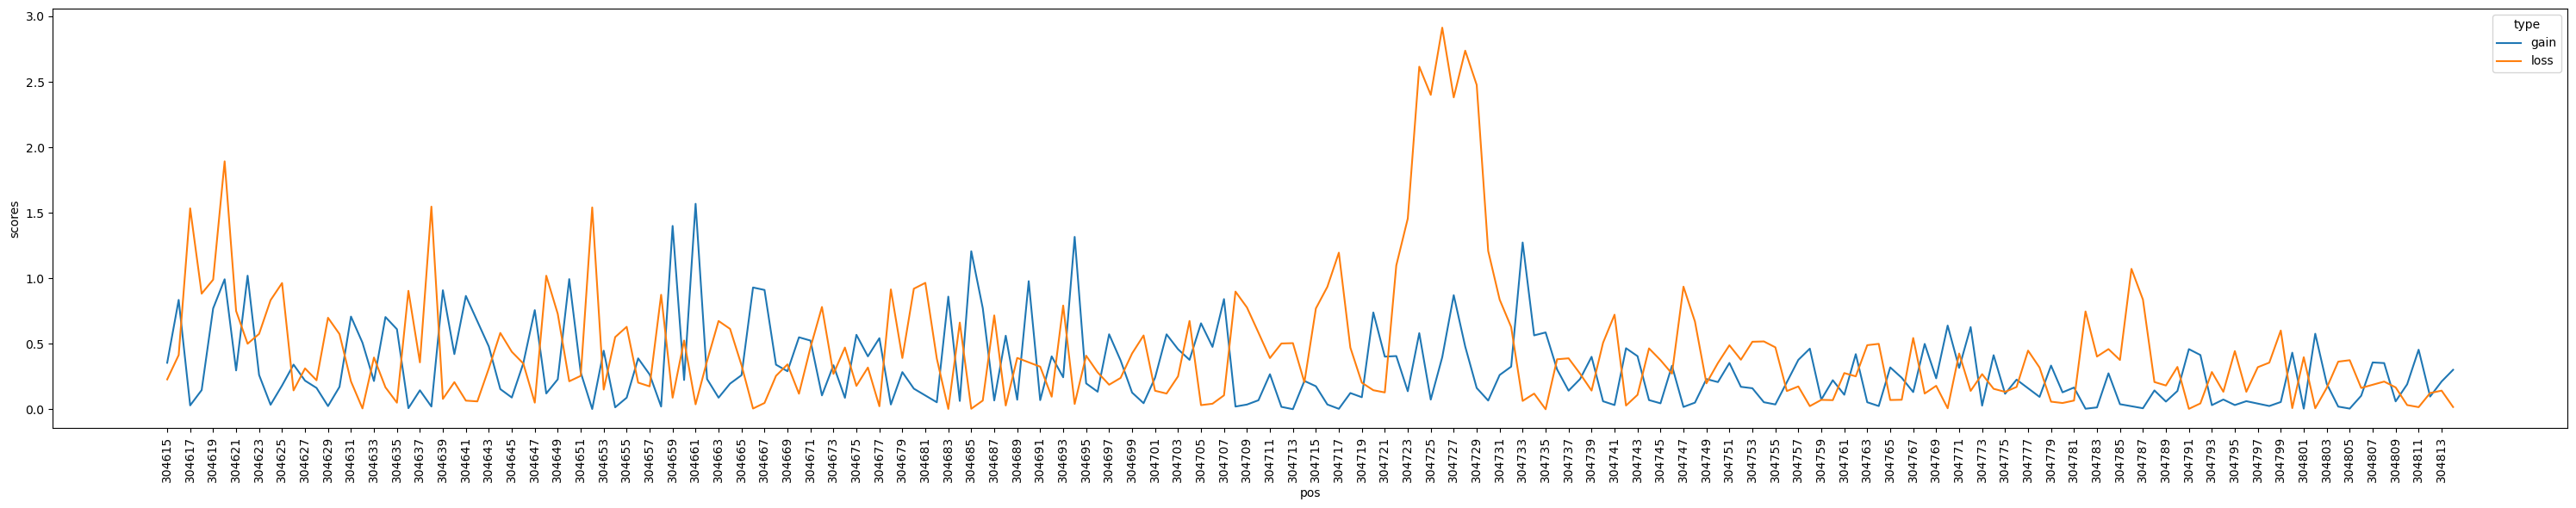

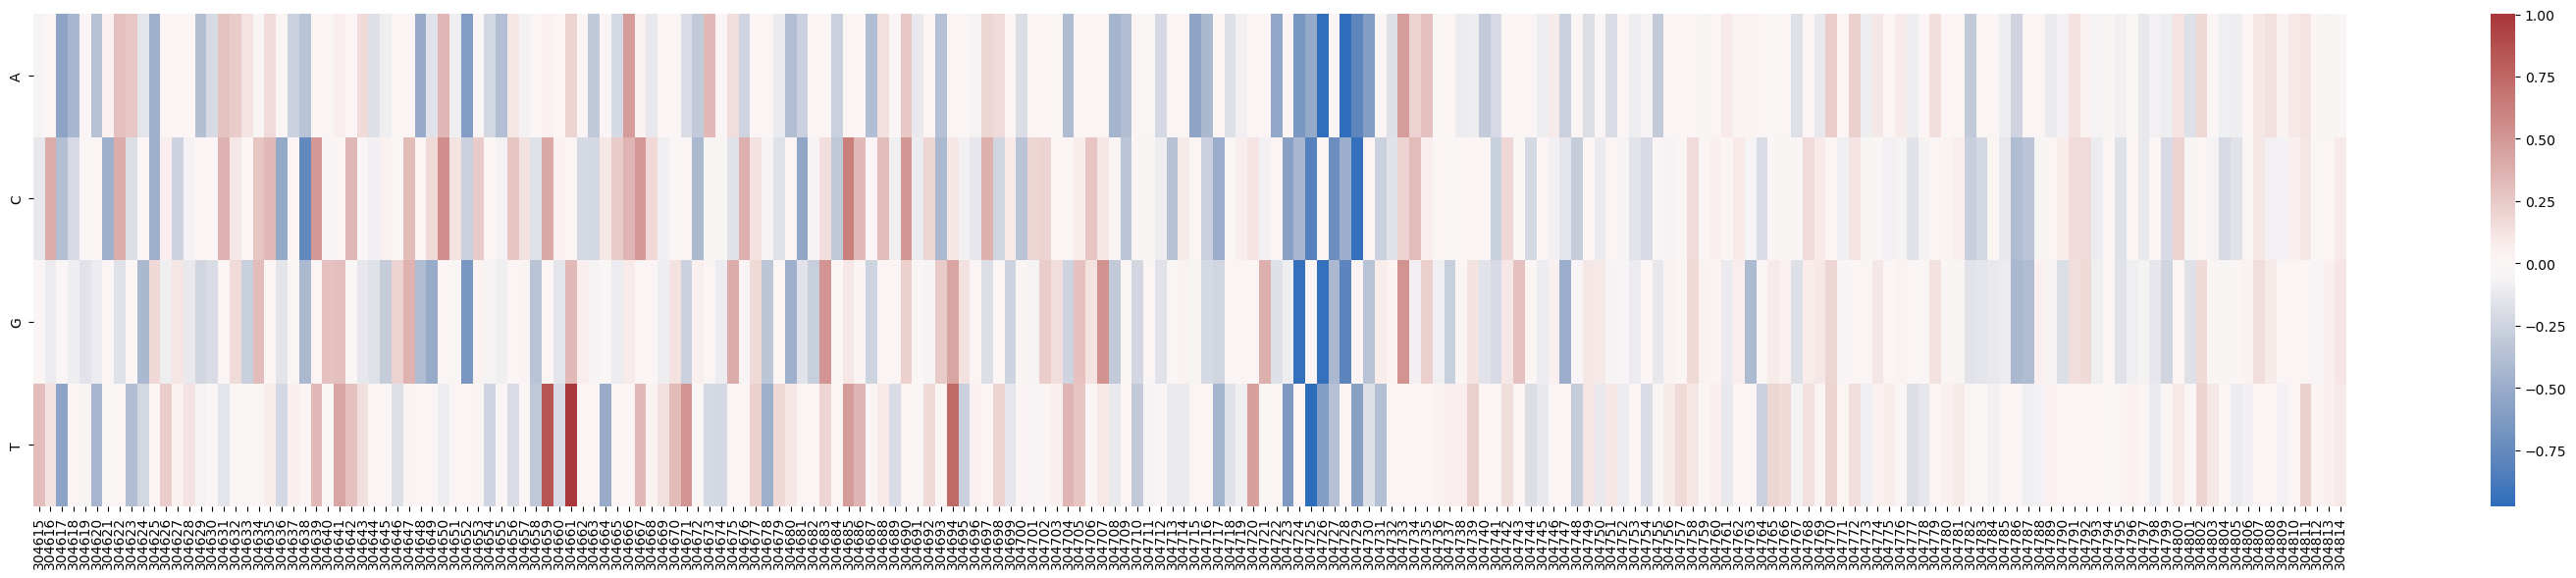

In [37]:
chrom=1
center=304715


start = center-512

name="vg{:02d}{:08d}".format(chrom, center)
print(name)

environ['name']=name

with open('../variation/batch/{}.batch.bed'.format(name), 'w+') as f:
    for i in range(1024):
        f.write('{}\t{}\t{}\n'.format(chrom, center-511+i-512, center-511+i+512))

!bedtools getfasta -fi ../genome/oryza_sativa.fa -bed ../variation/batch/$name.batch.bed > ../variation/batch/$name.batch.fa

mut_path = '../variation/batch/{}.batch.fa'.format(name)
seqs = utils.load_data(mut_path)
X_ref, X_alt = single_nucl_mutation_at_middle(seqs)

X_cat = X_ref+X_alt

batch_size = 512

pre_dataset = data.NucDataset(x=X_cat, y=[0]*len(X_cat))
pre_loader = torch.utils.data.DataLoader(dataset=pre_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

total_pre = torch.tensor([[0]*n_feature],dtype=torch.float)

with torch.no_grad():
    print('Start prediction, total: ', len(X_cat))
    for i, (inputs, _) in enumerate(pre_loader):
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        try:
            total_pre = torch.concat((total_pre, outputs.to(cpu, dtype=torch.float)))
        except:
            total_pre = torch.concat((total_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))

        print(i+1, ((i+1)*batch_size)/len(X_cat))

total_pre = total_pre[1:].numpy()

total_pre_scores = sc_projection(total_pre, ordered_profiles)

source = total_pre_scores[0:len(seqs[0])]
target = total_pre_scores[len(seqs[0]):]

scores = []
for ind, i in enumerate(range(0, target.shape[0], 3)):
    for j in range(0,3):
        scores.append(target[i+j]-source[ind])

scores = np.vstack(scores)
sum_scores = np.sum(np.abs(scores), axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))
plot_data = pd.DataFrame([ [rec, 'alt'+str(i%3+1) ]  for i, rec in enumerate(sum_scores) ])
plot_data.columns = ['scores','alt']
plot_data['pos'] = plot_data.index//3+1

sns.lineplot(plot_data,x='pos', y='scores', hue='alt')
plt.xticks(range(0, 1024, 128), range(start, start+1024, 128))
plt.show()

cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
ordered_category = np.array([ cluster_def['category']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['category'] ])

asc_ind = {}
for i, rec in enumerate(ordered_category):
    if rec in asc_ind:
        asc_ind[rec].append(i)
    else:
        asc_ind[rec] = [i]

result = []
for rec in (scores):
    tmp = {}
    for key in asc_ind:
        tmp[key] = np.sum(rec[asc_ind[key]])
    result.append(tmp)

plot_data = []
for i, rec in enumerate(result):
    pos = i//3
    alt = i%3
    db = ['A','T','C','G']
    db.pop(db.index(seqs[511][pos]))
    for key in rec:
        tmp = {'pos': pos, 'alt': db[alt], 'scores': rec[key], 'category': key}
        plot_data.append(tmp)

pdata = pd.DataFrame(plot_data)

gain = pdata[pdata.scores>0].groupby('pos').sum()
gain['type'] = 'gain'
gain['pos'] = gain.index 
loss = pdata[pdata.scores<=0].groupby('pos').sum()
loss['scores'] = loss['scores'].abs()
loss['type'] = 'loss'
loss['pos'] = loss.index

cate_sun_pdata = pd.concat([gain,loss])

fig = plt.figure(figsize=(30,6))
sns.lineplot(cate_sun_pdata.loc[cate_sun_pdata['pos'].isin(list(range(412,612)))], x='pos',y='scores', hue='type')
plt.xticks(range(412, 612, 2), labels=range(412+start, 612+start, 2), rotation=90)
plt.tight_layout()
plt.show()

heatp_data = pdata.groupby(['pos', 'alt']).sum()
pos_ind = [ i[0] for i in heatp_data.index ]
alt_ind = [ i[1] for i in heatp_data.index ]
heatp_data['pos'] = pos_ind
heatp_data['alt'] = alt_ind
heatp_data.index = pos_ind

var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

values_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    values_result.append(np.insert(var_values[i], ref_ind, 0))
values_result = np.array(values_result)

fig = plt.figure(figsize=(30,6))
sns.heatmap(values_result[412:612,].T, cmap='vlag', center=0, xticklabels = range(412+start, 612+start), yticklabels=ref_db)
plt.tight_layout()
plt.show()

var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

logo_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    tmp_values = [0,0,0,0]
    tmp_values[ref_ind] = abs(np.sum(var_values[i]))
    logo_result.append(tmp_values)
logo_result = np.array(logo_result)
np.savetxt("../variation/batch/{}_logoValues.csv".format(name), logo_result[412:612,].T, delimiter=',')

In [309]:
current_alt

array(['A', 'G', 'T'], dtype=object)

In [102]:
mut_path = '../variation/vg0105742026.fa'
seqs = utils.load_data(mut_path)
X_ref, X_alt = single_nucl_mutation_at_middle(seqs)

In [111]:
X_cat = X_ref+X_alt

batch_size = 512

pre_dataset = data.NucDataset(x=X_cat, y=[0]*len(X_cat))
pre_loader = torch.utils.data.DataLoader(dataset=pre_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

total_pre = torch.tensor([[0]*n_feature],dtype=torch.float)

with torch.no_grad():
    print('Start prediction, total: ', len(X_cat))
    for i, (inputs, _) in enumerate(pre_loader):
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        try:
            total_pre = torch.concat((total_pre, outputs.to(cpu, dtype=torch.float)))
        except:
            total_pre = torch.concat((total_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))

        print(i+1, ((i+1)*batch_size)/len(X_cat))

total_pre = total_pre[1:].numpy()

Start prediction, total:  4096
1 0.125
2 0.25
3 0.375
4 0.5
5 0.625
6 0.75
7 0.875
8 1.0


In [141]:
total_pre_scores = sc_projection(total_pre, ordered_profiles)

source = total_pre_scores[0:len(seqs[0])]
target = total_pre_scores[len(seqs[0]):]

scores = []
for ind, i in enumerate(range(0, target.shape[0], 3)):
    for j in range(0,3):
        scores.append(target[i+j]-source[ind])

scores = np.vstack(scores)
sum_scores = np.sum(np.abs(scores), axis=1)

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

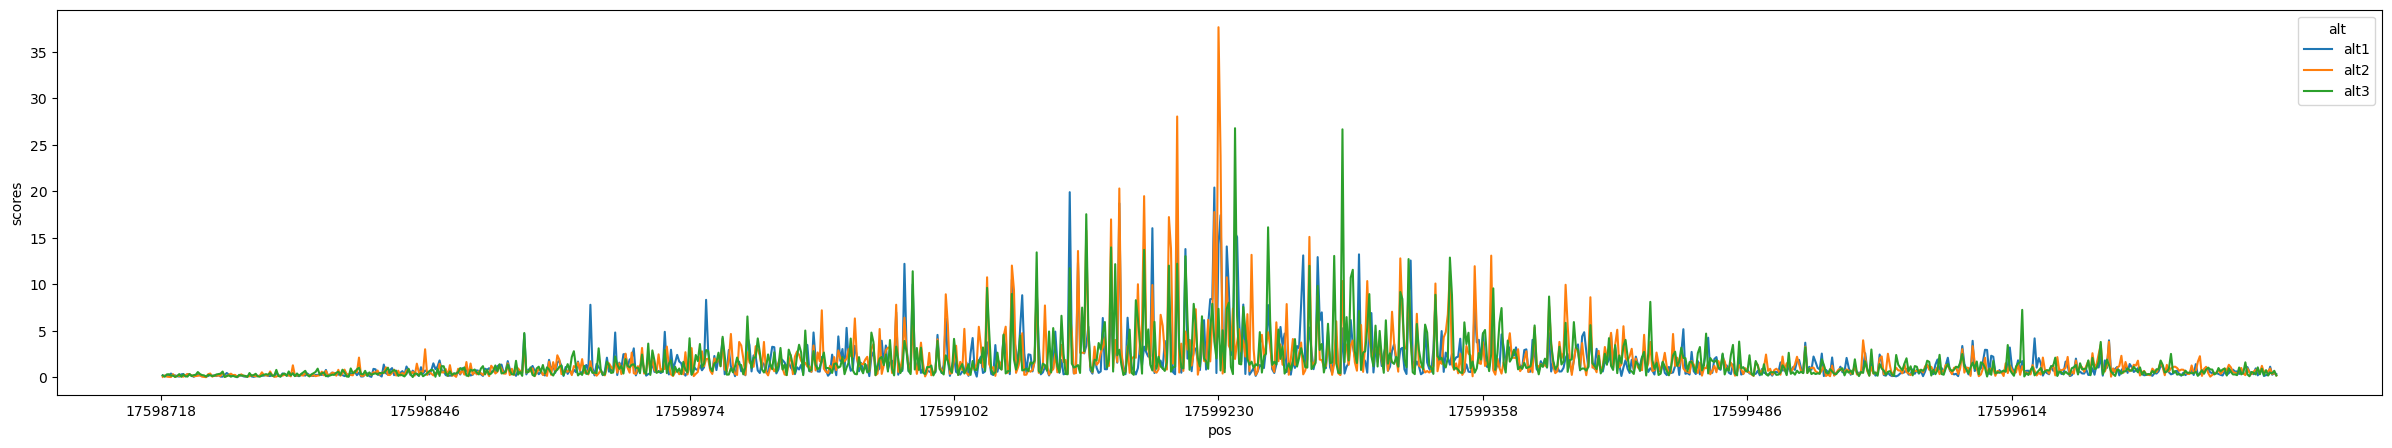

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))
plot_data = pd.DataFrame([ [rec, 'alt'+str(i%3+1) ]  for i, rec in enumerate(sum_scores) ])
plot_data.columns = ['scores','alt']
plot_data['pos'] = plot_data.index//3+1

sns.lineplot(plot_data,x='pos', y='scores', hue='alt')
plt.xticks(range(0, 1024, 128), range(start, start+1024, 128))
plt.show()

In [143]:
cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
ordered_category = np.array([ cluster_def['category']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['category'] ])

asc_ind = {}
for i, rec in enumerate(ordered_category):
    if rec in asc_ind:
        asc_ind[rec].append(i)
    else:
        asc_ind[rec] = [i]

result = []
for rec in (scores):
    tmp = {}
    for key in asc_ind:
        tmp[key] = np.sum(rec[asc_ind[key]])
    result.append(tmp)

plot_data = []
for i, rec in enumerate(result):
    pos = i//3
    alt = i%3
    db = ['A','T','C','G']
    db.pop(db.index(seqs[0][pos]))
    for key in rec:
        tmp = {'pos': pos, 'alt': db[alt], 'scores': rec[key], 'category': key}
        plot_data.append(tmp)

pdata = pd.DataFrame(plot_data)

In [144]:
gain = pdata[pdata.scores>0].groupby('pos').sum()
gain['type'] = 'gain'
gain['pos'] = gain.index 
loss = pdata[pdata.scores<=0].groupby('pos').sum()
loss['scores'] = loss['scores'].abs()
loss['type'] = 'loss'
loss['pos'] = loss.index

cate_sun_pdata = pd.concat([gain,loss])

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

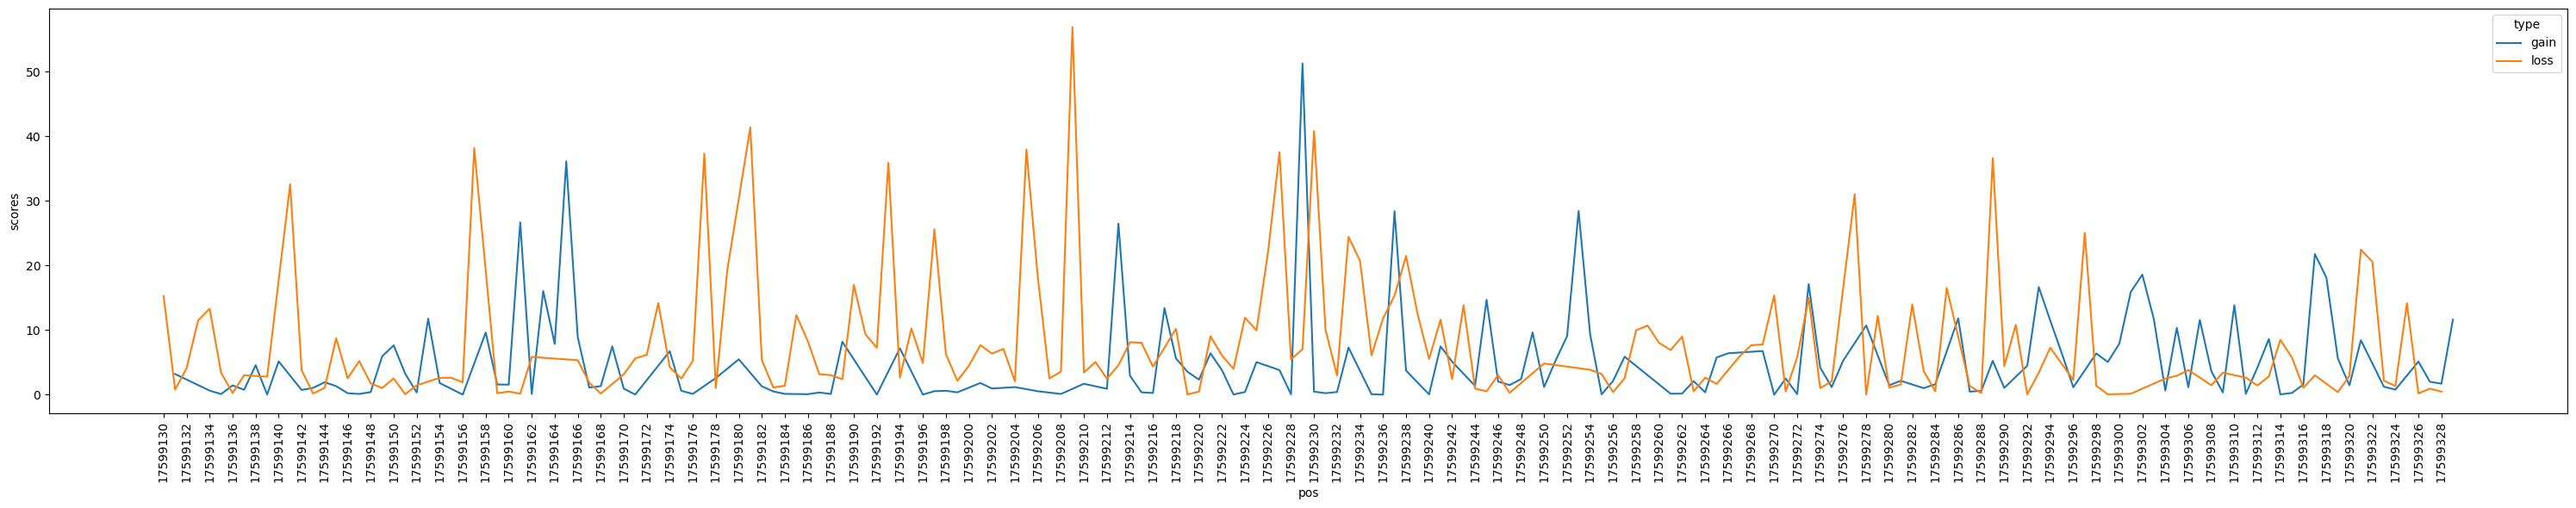

In [147]:
fig = plt.figure(figsize=(30,6))
sns.lineplot(cate_sun_pdata.loc[cate_sun_pdata['pos'].isin(list(range(412,612)))], x='pos',y='scores', hue='type')
plt.xticks(range(412, 612, 2), labels=range(412+start, 612+start, 2), rotation=90)
plt.tight_layout()
plt.savefig('../figures/variation_DEP1.pdf', dpi=300)
plt.show()

In [148]:
sum_pdata = pdata.groupby('pos').sum()
sum_pdata['pos']=sum_pdata.index

In [149]:
pc_pdata = pdata.loc[pdata['pos'].isin(list(range(412,612)))].groupby(['pos','category']).sum()

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

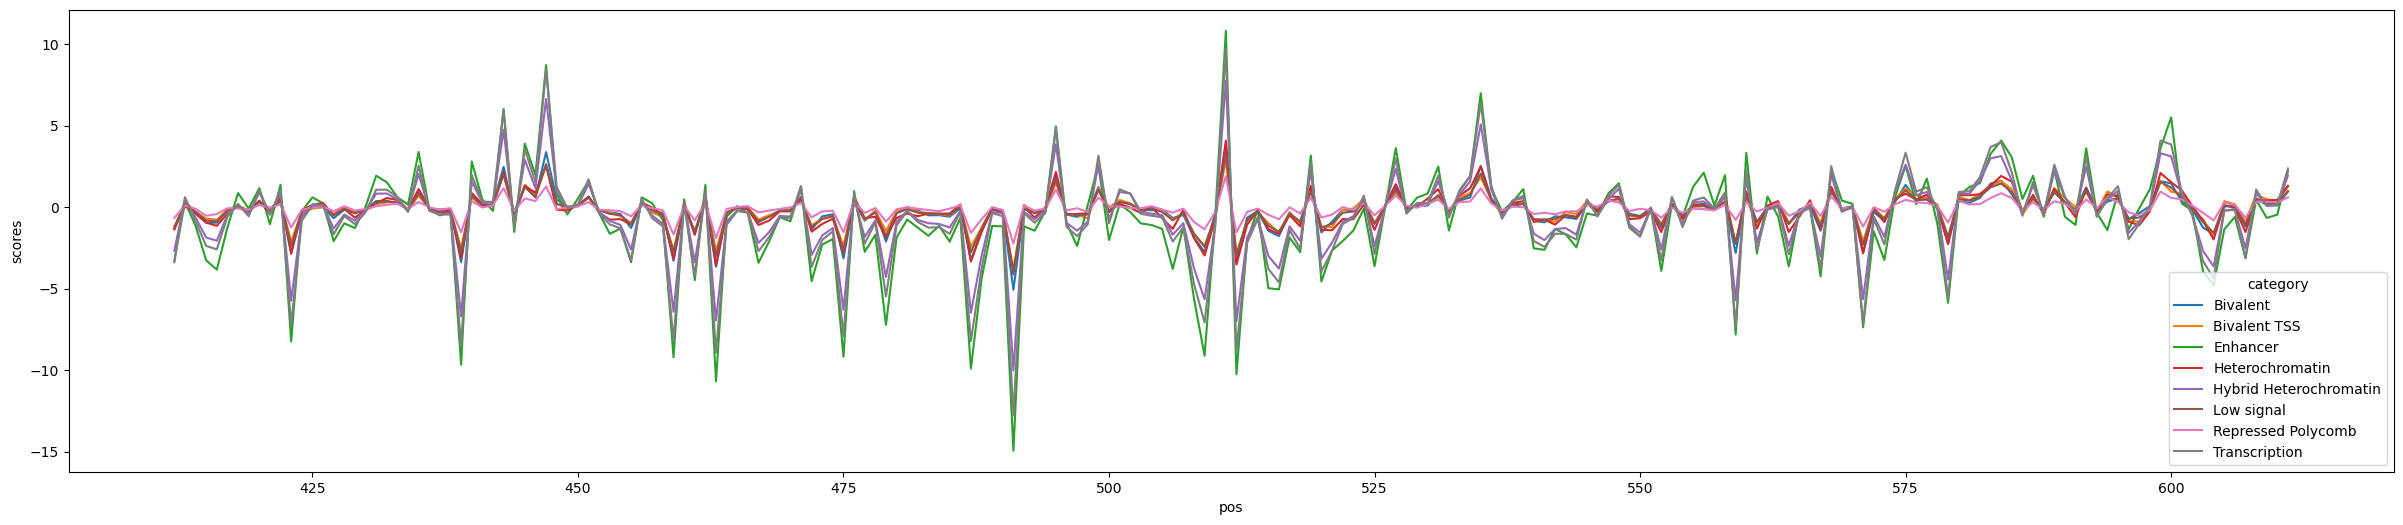

In [150]:
fig = plt.figure(figsize=(30,6))
sns.lineplot(pc_pdata, x='pos', hue='category', y='scores')
plt.show()

In [64]:
mut_path = '../variation/DEP1.fa'
seqs = utils.load_data(mut_path)
coor = open('../variation/DEP1.bed').readlines()[0].strip()
start = int(coor.split('\t')[1])+1
X_alt = single_nucl_mutation(seqs[0])
print("Total seq: {}, start: {}".format(len(X_alt), start))

Total seq: 3073, start: 17598718


In [65]:
batch_size = 512

pre_dataset = data.NucDataset(x=X_alt, y=[0]*len(X_alt))
pre_loader = torch.utils.data.DataLoader(dataset=pre_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

total_pre = torch.tensor([[0]*n_feature],dtype=torch.float)

with torch.no_grad():
    print('Start prediction, total: ', len(X_alt))
    for i, (inputs, _) in enumerate(pre_loader):
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        try:
            total_pre = torch.concat((total_pre, outputs.to(cpu, dtype=torch.float)))
        except:
            total_pre = torch.concat((total_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))
        if i%100 == 0:
            print(i, i/len(pre_loader))

total_pre = total_pre[1:].numpy()

Start prediction, total:  3073
0 0.0


In [66]:
ordered_profiles = np.load('../prediction/{}.cluster_ordered_profiles.npy'.format(record_pattern))
ordered_profiles

array([[0.00373574, 0.0307223 , 0.009704  , ..., 0.04107953, 0.03291423,
        0.03283232],
       [0.00190022, 0.06578298, 0.01765041, ..., 0.02947972, 0.00545742,
        0.0570226 ],
       [0.00028321, 0.00532696, 0.02634371, ..., 0.07933169, 0.00110667,
        0.01900006],
       ...,
       [0.00059605, 0.02832974, 0.00731097, ..., 0.023128  , 0.00055966,
        0.05336173],
       [0.03163039, 0.0115665 , 0.02589212, ..., 0.045913  , 0.06035614,
        0.01569095],
       [0.00357441, 0.00116592, 0.00854557, ..., 0.00036603, 0.12939233,
        0.00883933]], dtype=float32)

In [67]:
total_pre_scores = sc_projection(total_pre, ordered_profiles)
source = total_pre_scores[0]
target = total_pre_scores[1:]
scores = target-source
scores = np.sum(np.abs(scores), axis=1)

In [68]:
source

array([5.6394215 , 4.805241  , 4.7135677 , 3.8167853 , 7.4792614 ,
       0.4636562 , 2.5439289 , 2.6507642 , 2.6047401 , 0.8995976 ,
       1.0180783 , 3.367223  , 0.43086058, 1.4845282 , 3.110931  ,
       0.18138233, 0.26940522, 1.9984163 , 2.9287496 , 4.24251   ,
       0.18241796, 0.20460346, 2.0982893 , 0.6660032 , 1.0379444 ,
       1.4261596 , 0.69644725, 0.60214365, 0.61583453, 5.757594  ,
       3.6653795 , 5.4652967 , 3.4298856 , 0.96666676], dtype=float32)

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

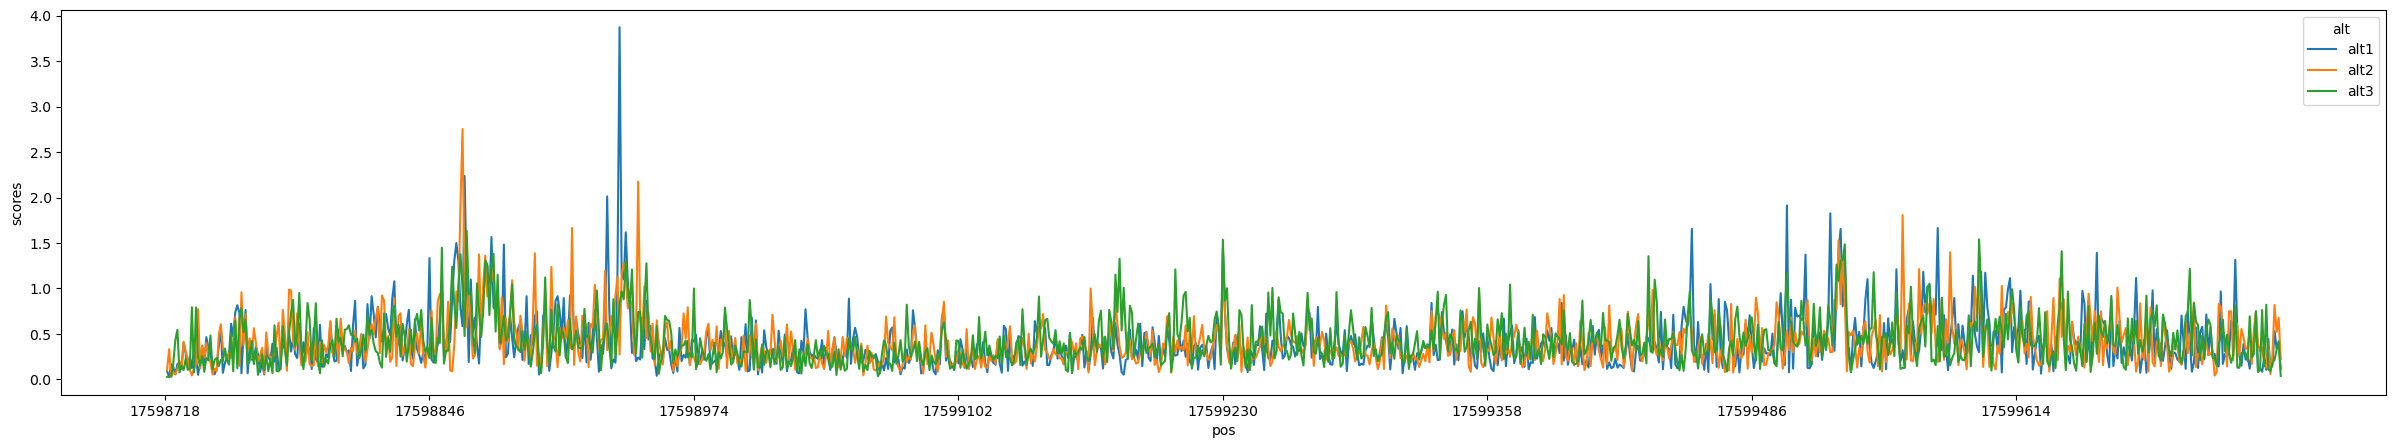

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30,5))
plot_data = pd.DataFrame([ [rec, 'alt'+str(i%3+1) ]  for i, rec in enumerate(scores) ])
plot_data.columns = ['scores','alt']
plot_data['pos'] = plot_data.index//3+1

sns.lineplot(plot_data,x='pos', y='scores', hue='alt')
plt.xticks(range(0, 1024, 128), range(start, start+1024, 128))
plt.show()

In [70]:
cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
ordered_category = np.array([ cluster_def['category']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['category'] ])

asc_ind = {}
for i, rec in enumerate(ordered_category):
    if rec in asc_ind:
        asc_ind[rec].append(i)
    else:
        asc_ind[rec] = [i]

result = []
for rec in (target-source):
    tmp = {}
    for key in asc_ind:
        tmp[key] = np.sum(rec[asc_ind[key]])
    result.append(tmp)

plot_data = []
for i, rec in enumerate(result):
    pos = i//3
    alt = i%3
    db = ['A','T','C','G']
    db.pop(db.index(seqs[0][pos]))
    for key in rec:
        tmp = {'pos': pos, 'alt': db[alt], 'scores': rec[key], 'category': key}
        plot_data.append(tmp)

pdata = pd.DataFrame(plot_data)

In [71]:
pdata.loc[pdata['pos'].isin(list(range(412,613)))]

pos alt    scores                category
9888   412   A -0.055171              Low signal
9889   412   A -0.047263                Bivalent
9890   412   A -0.037545  Hybrid Heterochromatin
9891   412   A -0.045950           Transcription
9892   412   A -0.043490            Bivalent TSS
...    ...  ..       ...                     ...
14707  612   G -0.074170           Transcription
14708  612   G -0.067223            Bivalent TSS
14709  612   G -0.043280                Enhancer
14710  612   G -0.069288      Repressed Polycomb
14711  612   G -0.114565         Heterochromatin

[4824 rows x 4 columns]

In [72]:
pdata[pdata.scores<=0].groupby('pos').sum()

alt    scores  \
pos                                        
0     AAAAAAAATTTTTTTTCCCCCCCC -0.219770   
1                           AG -0.003318   
2                     AAAAAAAA -0.167163   
3                AAAAAAAATTTTT -0.178245   
4                   AAAAAAATTT -0.068762   
...                        ...       ...   
1018              TTTTTTTCCCCG -0.130262   
1019                  CCCCCCCC -0.271897   
1020  AAAAAAAATTTTTTTTGGGGGGGG -1.557893   
1021  AAAAAAAATTTTTTTTCCCCCCCC -1.186629   
1023     AAAAAAAATTTTTTTTCCCCC -0.356027   

                                               category  
pos                                                      
0     Low signalBivalentHybrid HeterochromatinTransc...  
1                            Repressed PolycombEnhancer  
2     Low signalBivalentHybrid HeterochromatinTransc...  
3     Low signalBivalentHybrid HeterochromatinTransc...  
4     Low signalBivalentHybrid HeterochromatinTransc...  
...                                                 ...  
1018  Low signalBivalentHybrid HeterochromatinTransc...  
1019  Low signalBivalentHybrid HeterochromatinTransc...  
1020  Low signalBivalentHybrid HeterochromatinTransc...  
1021  Low signalBivalentHybrid HeterochromatinTransc...  
1023  Low signalBivalentHybrid HeterochromatinTransc...  

[981 rows x 3 columns]

In [73]:
gain = pdata[pdata.scores>0].groupby('pos').sum()
gain['type'] = 'gain'
gain['pos'] = gain.index 
loss = pdata[pdata.scores<=0].groupby('pos').sum()
loss['scores'] = loss['scores'].abs()
loss['type'] = 'loss'
loss['pos'] = loss.index

cate_sun_pdata = pd.concat([gain,loss])

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

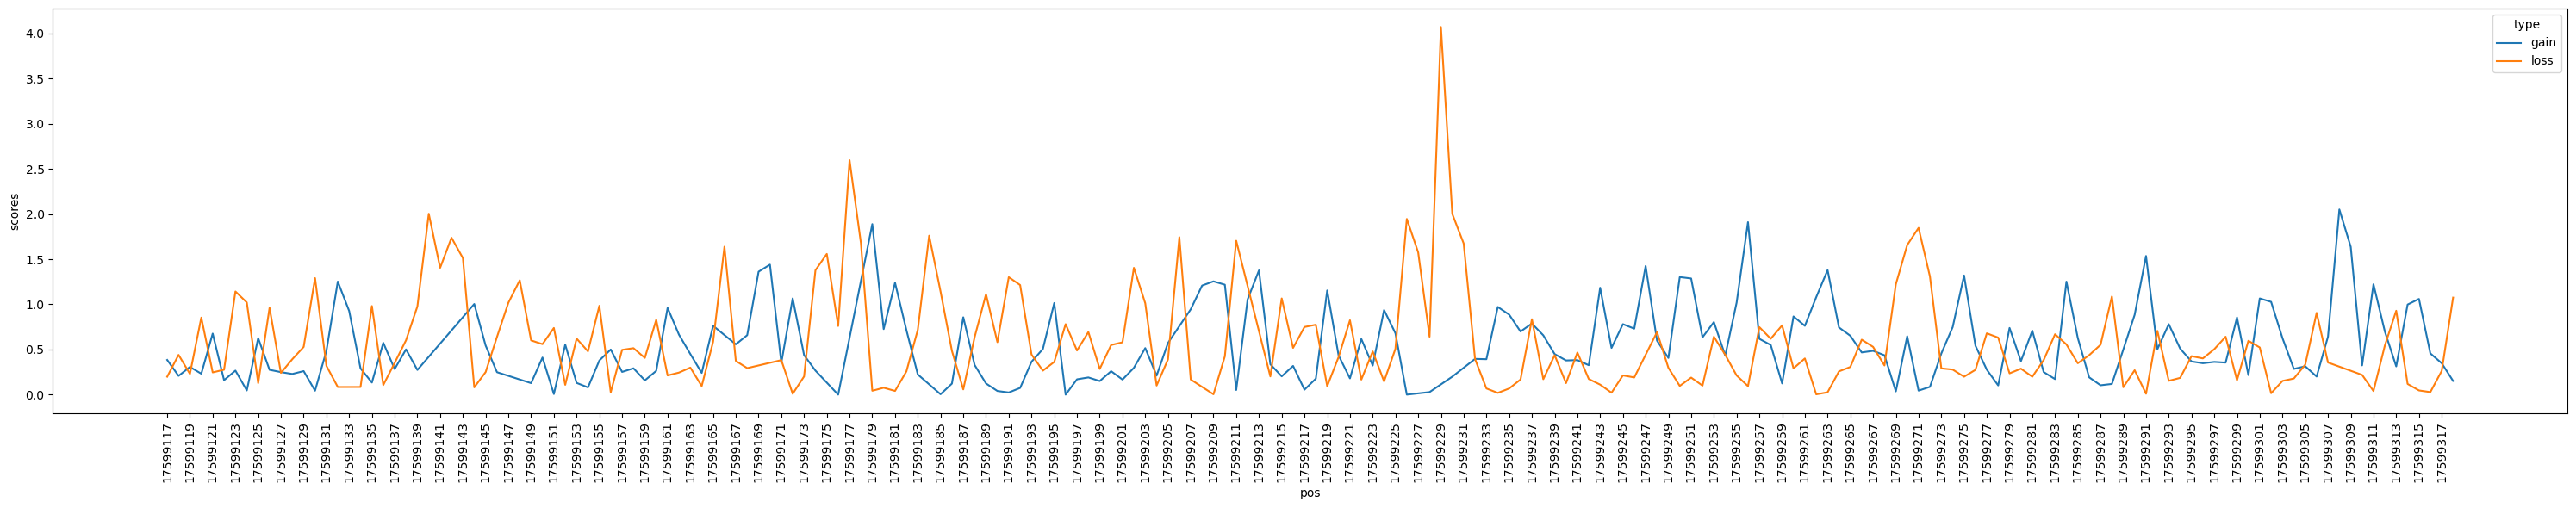

In [74]:
fig = plt.figure(figsize=(30,6))
sns.lineplot(cate_sun_pdata.loc[cate_sun_pdata['pos'].isin(list(range(399,601)))], x='pos',y='scores', hue='type')
plt.xticks(range(399, 601, 2), labels=range(399+start, 601+start, 2), rotation=90)
plt.tight_layout()
plt.savefig('../figures/variation_DEP1.pdf', dpi=300)
plt.show()

In [75]:
heatp_data = pdata.groupby(['pos', 'alt']).sum()
pos_ind = [ i[0] for i in heatp_data.index ]
alt_ind = [ i[1] for i in heatp_data.index ]
heatp_data['pos'] = pos_ind
heatp_data['alt'] = alt_ind
heatp_data.index = pos_ind

In [76]:
var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

values_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    values_result.append(np.insert(var_values[i], ref_ind, 0))
values_result = np.array(values_result)

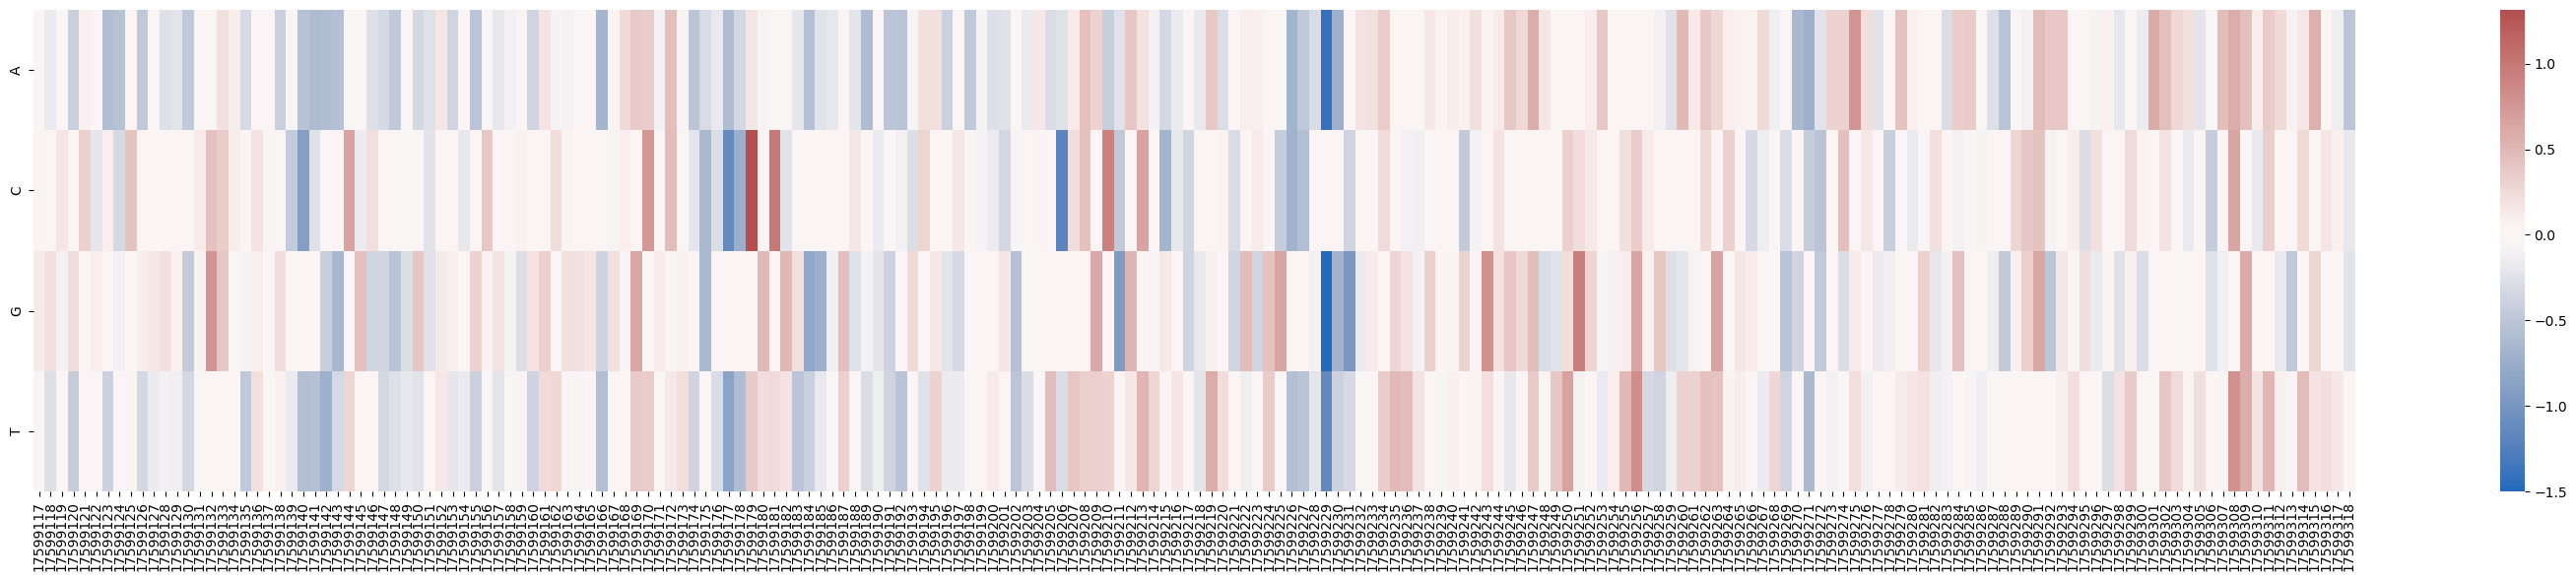

In [77]:
fig = plt.figure(figsize=(30,6))
sns.heatmap(values_result[399:601,].T, cmap='vlag', center=0, xticklabels = range(399+start, 601+start), yticklabels=ref_db)
plt.tight_layout()
plt.savefig('../figures/variation_DEP1_heatmap.pdf', dpi=300)
plt.show()

In [78]:
var_values = heatp_data['scores'].values.reshape(-1,3)
alt_values = heatp_data['alt'].values.reshape(-1,3)
ref_db = ['A','C','G','T']

logo_result = []
for i in range(var_values.shape[0]):
    current_alt = alt_values[i]
    ref = [ i for i in ref_db if i not in current_alt ][0]
    ref_ind = ref_db.index(ref)
    tmp_values = [0,0,0,0]
    tmp_values[ref_ind] = abs(np.sum(var_values[i]))
    logo_result.append(tmp_values)
logo_result = np.array(logo_result)

In [79]:
np.savetxt("../variation/variation_DEP1_logoValues.csv", logo_result[399:601,].T, delimiter=',')

In [80]:
sum_pdata = pdata.groupby('pos').sum()
sum_pdata['pos']=sum_pdata.index

In [81]:
pc_pdata

alt    scores
pos category                             
412 Bivalent                ATG -1.197332
    Bivalent TSS            ATG -0.963403
    Enhancer                ATG -2.176947
    Heterochromatin         ATG -0.754837
    Hybrid Heterochromatin  ATG -2.058726
...                         ...       ...
611 Heterochromatin         ATC  0.596860
    Hybrid Heterochromatin  ATC  0.759000
    Low signal              ATC  0.419689
    Repressed Polycomb      ATC  0.244454
    Transcription           ATC  0.966765

[1600 rows x 2 columns]

In [82]:
pc_pdata = pdata.loc[pdata['pos'].isin(list(range(412,612)))].groupby(['pos','category']).sum()

//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
//mnt/Omics2/zhouxk/anaconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(nam

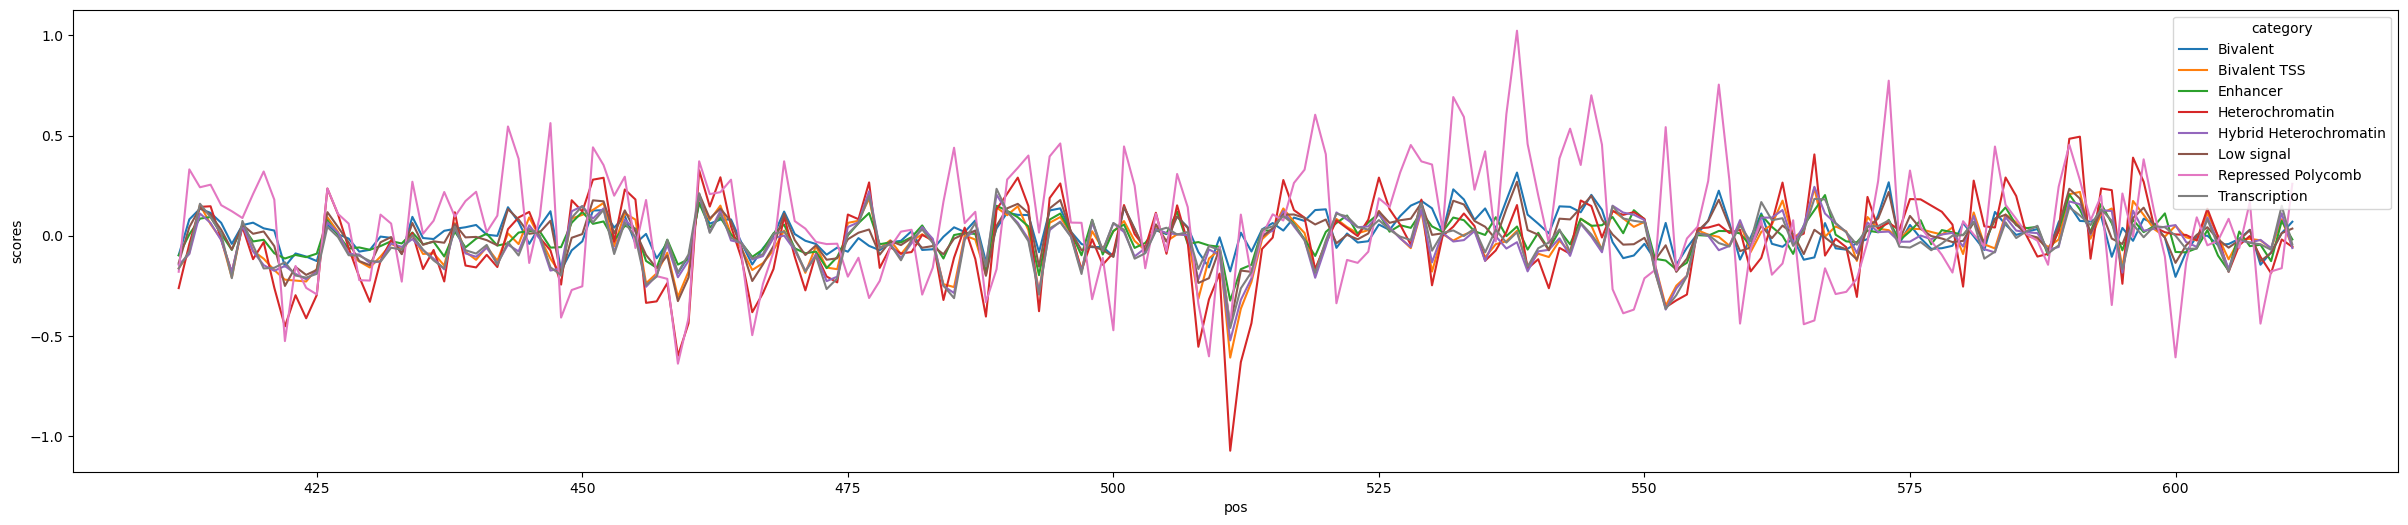

In [83]:
fig = plt.figure(figsize=(30,6))
sns.lineplot(pc_pdata, x='pos', hue='category', y='scores')
plt.show()

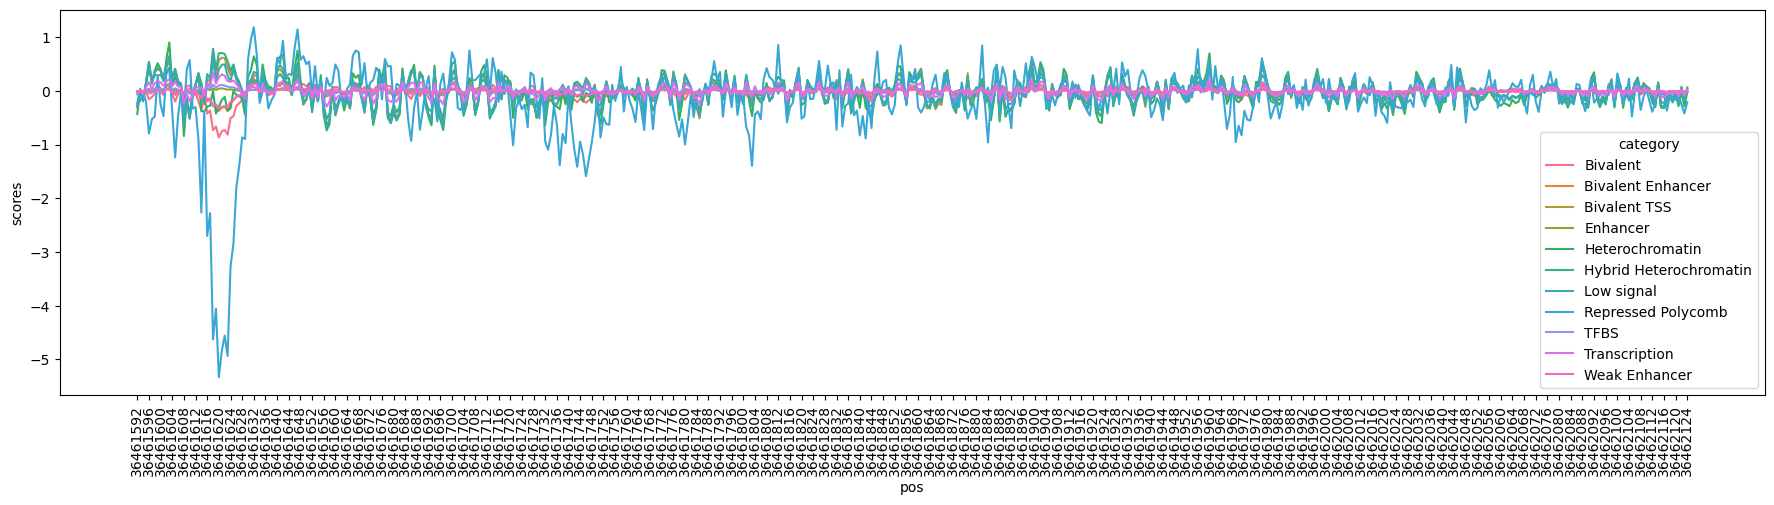

In [316]:
fig = plt.figure(figsize=(22,5))
sns.lineplot(pc_pdata, x='pos', hue='category', y='scores')
plt.xticks(range(311, 844, 4), labels=range(311+start, 844+start, 4), rotation=90)
plt.show()

([<matplotlib.axis.XTick at 0x7f229b105e80>,
 [Text(411, 0, '36461692'),
  Text(415, 0, '36461696'),
  Text(419, 0, '36461700'),
  Text(423, 0, '36461704'),
  Text(427, 0, '36461708'),
  Text(431, 0, '36461712'),
  Text(435, 0, '36461716'),
  Text(439, 0, '36461720'),
  Text(443, 0, '36461724'),
  Text(447, 0, '36461728'),
  Text(451, 0, '36461732'),
  Text(455, 0, '36461736'),
  Text(459, 0, '36461740'),
  Text(463, 0, '36461744'),
  Text(467, 0, '36461748'),
  Text(471, 0, '36461752'),
  Text(475, 0, '36461756'),
  Text(479, 0, '36461760'),
  Text(483, 0, '36461764'),
  Text(487, 0, '36461768'),
  Text(491, 0, '36461772'),
  Text(495, 0, '36461776'),
  Text(499, 0, '36461780'),
  Text(503, 0, '36461784'),
  Text(507, 0, '36461788'),
  Text(511, 0, '36461792'),
  Text(515, 0, '36461796'),
  Text(519, 0, '36461800'),
  Text(523, 0, '36461804'),
  Text(527, 0, '36461808'),
  Text(531, 0, '36461812'),
  Text(535, 0, '36461816'),
  Text(539, 0, '36461820'),
  Text(543, 0, '36461824'),
  T

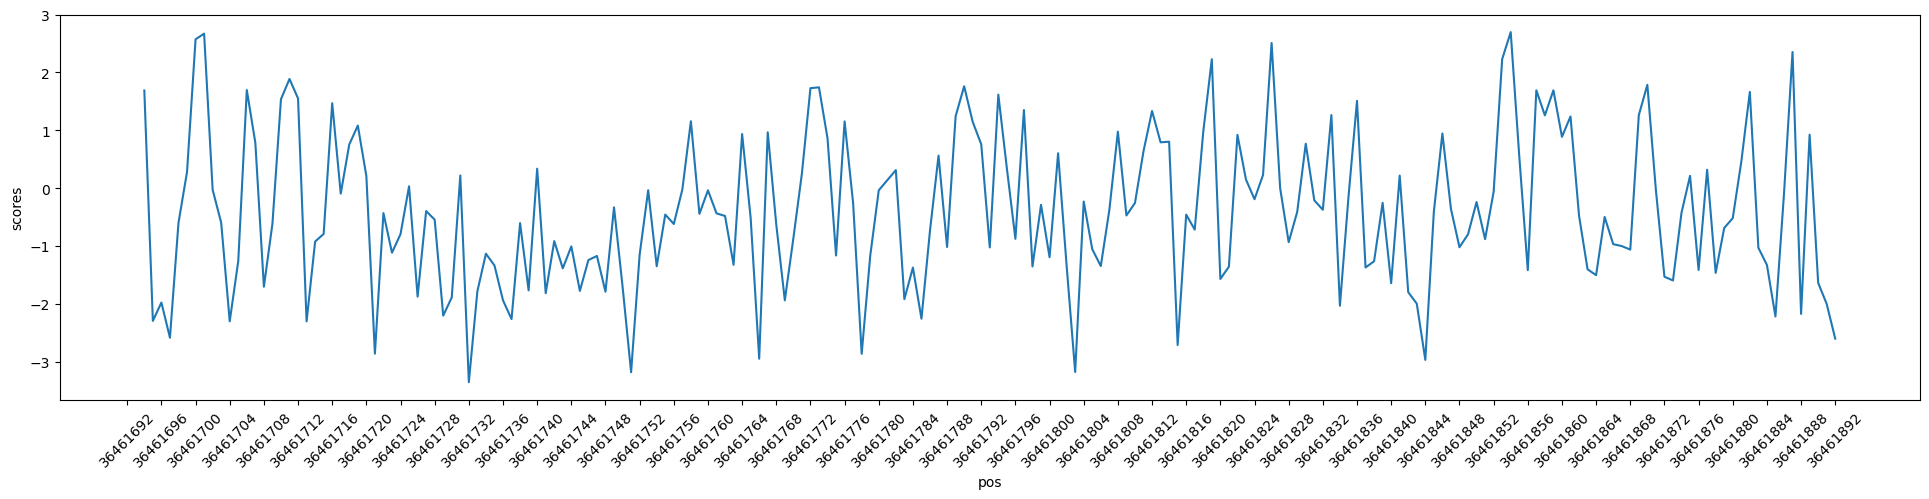

In [317]:
fig = plt.figure(figsize=(24,5))
sns.lineplot(sum_pdata.loc[sum_pdata['pos'].isin(list(range(413,612)))], x='pos',y='scores')
plt.xticks(range(411, 612, 4), labels=range(411+start, 612+start, 4), rotation=45)

In [133]:
result

[{'Low signal': -0.057345867,
  'Bivalent Enhancer': -0.02103138,
  'Hybrid Heterochromatin': -0.041213274,
  'Transcription': -0.029618979,
  'Bivalent TSS': -0.054403305,
  'Enhancer': -0.00627847,
  'Repressed Polycomb': -0.09398937,
  'Heterochromatin': -0.06333502,
  'Bivalent': -0.022146225,
  'Weak Enhancer': -0.0070495605,
  'TFBS': -0.006423712},
 {'Low signal': -0.05162096,
  'Bivalent Enhancer': -0.02363491,
  'Hybrid Heterochromatin': -0.034682035,
  'Transcription': -0.026826859,
  'Bivalent TSS': -0.04814434,
  'Enhancer': -0.006279364,
  'Repressed Polycomb': -0.1354351,
  'Heterochromatin': -0.06455141,
  'Bivalent': -0.028778553,
  'Weak Enhancer': -0.009660244,
  'TFBS': -0.0055294037},
 {'Low signal': 0.01960516,
  'Bivalent Enhancer': 0.0032405853,
  'Hybrid Heterochromatin': 0.017296076,
  'Transcription': 0.011879206,
  'Bivalent TSS': 0.017466545,
  'Enhancer': 0.003266275,
  'Repressed Polycomb': -0.011276722,
  'Heterochromatin': 0.018506646,
  'Bivalent': 0.00

In [11]:
cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()

In [119]:
result = []
for rec in (target-source):
    tmp = {}
    for key in asc:
        tmp[key] = np.sum(rec[asc[key]])
    result.append(tmp)
result

[{'Low signal': -0.057345867,
  'Bivalent Enhancer': -0.02103138,
  'Hybrid Heterochromatin': -0.041213274,
  'Transcription': -0.029618979,
  'Bivalent TSS': -0.054403305,
  'Enhancer': -0.00627847,
  'Repressed Polycomb': -0.09398937,
  'Heterochromatin': -0.06333502,
  'Bivalent': -0.022146225,
  'Weak Enhancer': -0.0070495605,
  'TFBS': -0.006423712},
 {'Low signal': -0.05162096,
  'Bivalent Enhancer': -0.02363491,
  'Hybrid Heterochromatin': -0.034682035,
  'Transcription': -0.026826859,
  'Bivalent TSS': -0.04814434,
  'Enhancer': -0.006279364,
  'Repressed Polycomb': -0.1354351,
  'Heterochromatin': -0.06455141,
  'Bivalent': -0.028778553,
  'Weak Enhancer': -0.009660244,
  'TFBS': -0.0055294037},
 {'Low signal': 0.01960516,
  'Bivalent Enhancer': 0.0032405853,
  'Hybrid Heterochromatin': 0.017296076,
  'Transcription': 0.011879206,
  'Bivalent TSS': 0.017466545,
  'Enhancer': 0.003266275,
  'Repressed Polycomb': -0.011276722,
  'Heterochromatin': 0.018506646,
  'Bivalent': 0.00

In [124]:
aab = pd.DataFrame(result)
aab[pos]

Low signal  Bivalent Enhancer  Hybrid Heterochromatin  Transcription  \
0      -0.057346          -0.021031               -0.041213      -0.029619   
1      -0.051621          -0.023635               -0.034682      -0.026827   
2       0.019605           0.003241                0.017296       0.011879   
3      -0.080718          -0.058780               -0.045573      -0.053089   
4      -0.069616          -0.038079               -0.044683      -0.042944   
...          ...                ...                     ...            ...   
3067   -0.017994          -0.006734               -0.017492      -0.012583   
3068    0.010666           0.005219                0.007693       0.006329   
3069   -0.023244          -0.009579               -0.018997      -0.012518   
3070   -0.015007          -0.010162               -0.013028      -0.011192   
3071   -0.005816          -0.003261               -0.004506      -0.003219   

      Bivalent TSS  Enhancer  Repressed Polycomb  Heterochromatin  Bivalent  \
0        -0.054403 -0.006278           -0.093989        -0.063335 -0.022146   
1        -0.048144 -0.006279           -0.135435        -0.064551 -0.028779   
2         0.017467  0.003266           -0.011277         0.018507  0.001649   
3        -0.070339 -0.015256           -0.421093        -0.127917 -0.090714   
4        -0.062815 -0.010577           -0.232830        -0.092604 -0.053796   
...            ...       ...                 ...              ...       ...   
3067     -0.020024 -0.006075           -0.018252        -0.023448 -0.004979   
3068      0.008776  0.001838            0.031857         0.015867  0.006894   
3069     -0.024253 -0.004331           -0.044628        -0.031997 -0.008885   
3070     -0.015497 -0.005146           -0.063864        -0.027782 -0.013085   
3071     -0.005474 -0.001370           -0.021228        -0.010656 -0.004154   

      Weak Enhancer      TFBS  
0         -0.007050 -0.006424  
1         -0.009660 -0.005529  
2         -0.000042  0.002967  
3         -0.029359 -0.010336  
4         -0.016611 -0.008929  
...             ...       ...  
3067      -0.002549 -0.003835  
3068       0.002384  0.001273  
3069      -0.003723 -0.003140  
3070      -0.005145 -0.002829  
3071      -0.001616 -0.000732  

[3072 rows x 11 columns]

In [76]:
ordered_category = np.array([ cluster_def['category']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['category'] ])

In [118]:
asc = {}
for i, rec in enumerate(ordered_category):
    if rec in asc:
        asc[rec].append(i)
    else:
        asc[rec] = [i]
asc

{'Low signal': [0, 29],
 'Bivalent Enhancer': [1],
 'Hybrid Heterochromatin': [2, 32],
 'Transcription': [3, 7],
 'Bivalent TSS': [4, 31],
 'Enhancer': [5, 10, 16, 23],
 'Repressed Polycomb': [6, 8, 14, 17, 19],
 'Heterochromatin': [9, 12, 15, 18, 20, 21, 24, 25, 26, 27, 28, 30],
 'Bivalent': [11],
 'Weak Enhancer': [13],
 'TFBS': [22]}

In [67]:
np.unique(np.array(ordered_category)[source.argsort()[-5:]])

array(['Bivalent Enhancer', 'Bivalent TSS', 'Repressed Polycomb'],
      dtype='<U22')

In [79]:
[ ordered_category[ind] for ind in np.abs(target-source).argsort(axis=1)[:,-1] ]

['Bivalent TSS',
 'Repressed Polycomb',
 'Low signal',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Bivalent',
 'Repressed Polycomb',
 'Bivalent TSS',
 'Bivalent',
 'Low signal',
 'Repressed Polycomb',
 'Bivalent',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Bivalent TSS',
 'Repressed Polycomb',
 'Bivalent',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Bivalent TSS',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Bivalent',
 'Low signal',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Bivalent TSS',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',
 'Repressed Polycomb',


## Bulk variation

In [1]:
import torch
import numpy as np
import pandas as pd
import utils
import preprocess
import utils
import data

seq_len = 1024
n_feature = 467
record_pattern = 'sei_seq{}_nip_feature{}'.format(seq_len, n_feature)
model_dir = '../model/{}.model'.format(record_pattern)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

model = torch.load(model_dir).to(device)
model.eval()

leiden_wgt = np.load('../visualization/{}.leiden.npy'.format(record_pattern))
prediction = np.load('../prediction/predicted_matrix_{}.npy'.format(record_pattern))

In [2]:
def sc_projection(chromatin_profile_preds, clustervfeat):
    return np.dot(chromatin_profile_preds, clustervfeat.T)

def single_nucl_mutation(seqs, alts, pos=511):
    '''
    Get single nucl mutation along given sequence and alt and return encoded tensor
    '''

    seqlist = []
    for i, seq in enumerate(seqs):
        seqlist.append(seq)
        alt_seq = seq[0:pos]+alts[i]+seq[pos+1:]
        seqlist.append(alt_seq)

    alt_pre = preprocess.NucPreprocess(seqlist)
    X_alt = alt_pre.onehot_for_nuc()

    return X_alt

In [21]:
mut_path = '../MH63_ZS97/NIP_MH_ZS_var1k.fa'
seqs = utils.load_data(mut_path)
variations = [ rec.strip().split('-')[1] for rec in open('../MH63_ZS97/NIP_MH_ZS_var1k.trans.txt').readlines() ]

In [4]:
X_alt = single_nucl_mutation(seqs, variations)

In [7]:
from tqdm import tqdm
batch_size = 1024

pre_dataset = data.NucDataset(x=X_alt, y=[0]*len(X_alt))
pre_loader = torch.utils.data.DataLoader(dataset=pre_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

total_pre = torch.tensor([[0]*n_feature],dtype=torch.float)

with torch.no_grad():
    print('Start prediction, total: ', len(X_alt))
    for i, (inputs, _) in enumerate(tqdm(pre_loader)):
        inputs = inputs.to(device, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        outputs = model(inputs)
        outputs = outputs.squeeze()
        try:
            total_pre = torch.concat((total_pre, outputs.to(cpu, dtype=torch.float)))
        except:
            total_pre = torch.concat((total_pre, torch.unsqueeze(outputs.to(cpu, dtype=torch.float), dim=0)))

total_pre = total_pre[1:].numpy()

Start prediction, total:  2245308


100%|██████████| 2193/2193 [36:33<00:00,  1.00s/it]


In [16]:
np.save('../MH63_ZS97/NIP_MH_ZS_var1k.pred.npy', total_pre)

In [12]:
source = total_pre[range(0,len(total_pre)-1,2)]
target = total_pre[range(1,len(total_pre),2)]

cluster_def = np.load('../visualization/{}.cluster_def.npy'.format(record_pattern), allow_pickle=True).item()
ordered_category = np.array([ cluster_def['category']['cluster'+str(cluster)] for cluster in sorted(np.unique(leiden_wgt)) if 'cluster'+str(cluster) in cluster_def['category'] ])

asc_ind = {}
for i, rec in enumerate(ordered_category):
    if rec in asc_ind:
        asc_ind[rec].append(i)
    else:
        asc_ind[rec] = [i]

result = []
for rec in (target-source):
    tmp = {}
    for key in asc_ind:
        tmp[key] = np.sum(rec[asc_ind[key]])
    result.append(tmp)

<Axes: >

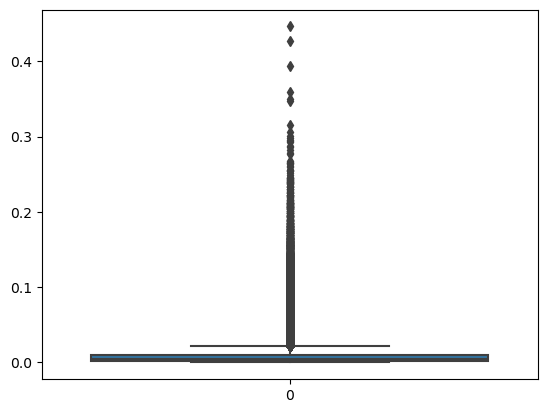

In [173]:
sns.boxplot(gain_enhancer)

In [325]:
enhancer_scores[np.concatenate([enhancer_scores.argsort()[:200],enhancer_scores.argsort()[-200:]])]

array([-0.19899602, -0.1722269 , -0.15656768, -0.14762942, -0.143947  ,
       -0.14149177, -0.13862398, -0.13837524, -0.1326714 , -0.13026115,
       -0.12591755, -0.12422737, -0.12111139, -0.12031905, -0.11892906,
       -0.11889423, -0.11749271, -0.11605138, -0.11561137, -0.11429185,
       -0.11259282, -0.11239761, -0.11193764, -0.11163345, -0.10990739,
       -0.10848846, -0.10723269, -0.10626996, -0.10606217, -0.105643  ,
       -0.10464317, -0.10275331, -0.10271098, -0.10235152, -0.10147177,
       -0.10130247, -0.10098565, -0.10011253, -0.09913519, -0.098746  ,
       -0.09802407, -0.09759301, -0.09753707, -0.09719253, -0.09663349,
       -0.09643859, -0.09623253, -0.09623113, -0.0962196 , -0.09546489,
       -0.09491187, -0.09476   , -0.0945197 , -0.09422757, -0.09308583,
       -0.09301586, -0.09281895, -0.09268644, -0.09163904, -0.0913039 ,
       -0.09106618, -0.09082368, -0.09079432, -0.09026429, -0.08934884,
       -0.08923626, -0.08871864, -0.08863273, -0.08815905, -0.08

In [320]:
enhancer_scores = np.array([rec['Enhancer']+rec['Transcription'] for rec in result])

In [267]:
mh_index = np.array([ int(rec.strip()) for rec in open('../MH63_ZS97/mh63_snp.index.txt').readlines() ])
zs_index = np.array([ rec for rec in range(len(enhancer_scores)) if rec not in mh_index ])

In [270]:
mh_escores = enhancer_scores[mh_index]
zs_escores = enhancer_scores[zs_index]

In [277]:
top=118114

enhancer_scores = zs_escores

gain_ind = np.where(enhancer_scores>0)[0]
gain_enhancer = enhancer_scores[gain_ind]
top_gain_enhancer_ind = gain_ind[gain_enhancer.argsort()[-top:]]

loss_ind = np.where(enhancer_scores<0)[0]
loss_enhancer = enhancer_scores[loss_ind]
top_loss_enhancer_ind = loss_ind[loss_enhancer.argsort()[:top]]

top_gain_enhancer = filter_bed[top_gain_enhancer_ind]
with open('../MH63_ZS97/NIP_MH_ZS_var1k_top{}_gain_enhancer.bed'.format(top), 'w') as f:
    for rec in top_gain_enhancer:
        f.write(rec)

top_loss_enhancer = filter_bed[top_loss_enhancer_ind]
with open('../MH63_ZS97/NIP_MH_ZS_var1k_top{}_loss_enhancer.bed'.format(top), 'w') as f:
    for rec in top_loss_enhancer:
        f.write(rec)

In [14]:
sorted_scores_ind = np.sum(np.abs(target-source), axis=1).argsort()

In [28]:
p10_ind = sorted_scores_ind[-int(len(sorted_scores_ind)*0.1):]

In [29]:
filter_bed = np.array(open('../MH63_ZS97/NIP_MH_ZS_var1k.filtered.bed').readlines())
top_p10 = filter_bed[p10_ind]

In [30]:
with open('../MH63_ZS97/NIP_MH_ZS_var1k_p10.bed', 'w') as f:
    for rec in top_p10:
        f.write(rec)

In [42]:
top_100_ind = sorted_scores_ind[-100:]
top_100 = filter_bed[top_100_ind]
with open('../MH63_ZS97/NIP_MH_ZS_var1k_top100.bed', 'w') as f:
    for rec in top_100:
        f.write(rec)

In [43]:
top_1000_ind = sorted_scores_ind[-1000:]
top_1000 = filter_bed[top_1000_ind]
with open('../MH63_ZS97/NIP_MH_ZS_var1k_top1000.bed', 'w') as f:
    for rec in top_1000:
        f.write(rec)

In [327]:
b10_ind = sorted_scores_ind[:int(len(sorted_scores_ind)*0.1)]
bottom_p10 = filter_bed[b10_ind]

with open('../MH63_ZS97/NIP_MH_ZS_var1k_b10.bed', 'w') as f:
    for rec in bottom_p10:
        f.write(rec)

In [364]:
p10_overlap = pd.read_csv('../MH63_ZS97/p10_overlap.csv', header=None)
rownames = [rec.strip() for rec in open('../MH63_ZS97/p10_overlap.list').readlines()]

p10_overlap.index = rownames
p10_overlap.columns = ['top', 'bottom', 'bg']
p10_overlap['bg'] = p10_overlap['bg']/10
p10_overlap

top  bottom        bg
ATAC regions   54314   12115   32949.9
ConsHMM CNS    23442    6750   17496.1
ConsHMM CS     37209    7981   25993.3
Core cons       6162    2929    5184.5
Core NC         4201    2665    3797.8
Gene           41261   10038   27027.9
Motif fimo    192203  118338  142340.1
Pan cons        1078     140     640.4
Pan NC           515      69     270.4
Repeat         30177   92904   54182.1
Sub cons         811     141     575.1
Sub NC           379      68     256.0
TFBS regions   18115    4982   13645.5

In [365]:
ordered_p10_overlap = p10_overlap.iloc[np.argsort(np.log2(p10_overlap.top/p10_overlap.bg))]

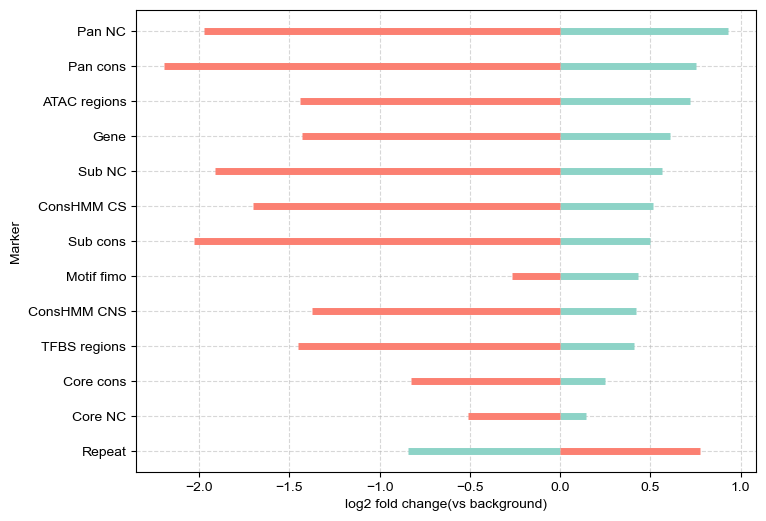

In [366]:
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(8,6))

plt.hlines(y=ordered_p10_overlap.index, xmax=np.log2(ordered_p10_overlap.top/ordered_p10_overlap.bg), xmin=0, linewidth=5, colors='#8dd3c7')
plt.hlines(y=ordered_p10_overlap.index, xmin=np.log2(ordered_p10_overlap.bottom/ordered_p10_overlap.bg), xmax=0, color='#fb8072', linewidth=5)

plt.gca().set(ylabel='Marker', xlabel='log2 fold change(vs background)')

plt.grid(linestyle='--', alpha=0.5)

fig.savefig('../visualization/variation_enrichment_p10_{}.pdf'.format(record_pattern), dpi=300)

In [33]:
from scipy.stats import fisher_exact

fisher_exact(np.array([[100, 17],[1122654-100, 136455-17]]))

SignificanceResult(statistic=0.7149557799341816, pvalue=0.2313898366901589)

In [146]:
top = 500
gain_df = pd.read_csv('../MH63_ZS97/results/{}_gain.tsv'.format(top), sep='\t', header=None)
gain_df.columns = ['NIP','MH63','ZS97']

loss_df = pd.read_csv('../MH63_ZS97/results/{}_loss.tsv'.format(top), sep='\t', header=None)
loss_df.columns = ['NIP','MH63','ZS97']

<Axes: >

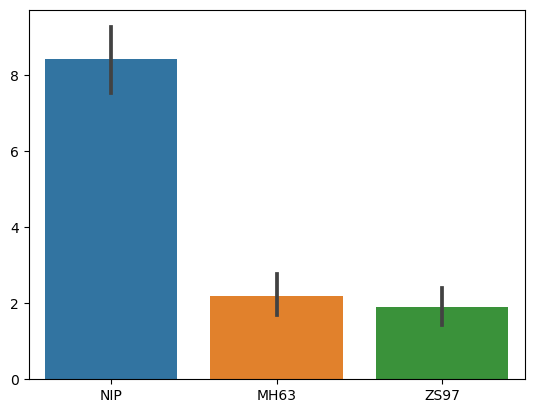

In [148]:
sns.barplot(loss_df)

In [283]:
import seaborn as sns
top = 118114

zs_gain = pd.read_csv('../MH63_ZS97/results/ZS97_{}_gain.tsv'.format(top), sep='\t', header=None)
zs_gain.columns = ['NIP','ZS97']
zs_gain = zs_gain[zs_gain['NIP']!=zs_gain['ZS97']]

zs_loss = pd.read_csv('../MH63_ZS97/results/ZS97_{}_loss.tsv'.format(top), sep='\t', header=None)
zs_loss.columns = ['NIP','ZS97']
zs_loss = zs_loss[zs_loss['NIP']!=zs_loss['ZS97']]

mh_gain = pd.read_csv('../MH63_ZS97/results/MH63_{}_gain.tsv'.format(top), sep='\t', header=None)
mh_gain.columns = ['NIP','MH63']
mh_gain = mh_gain[mh_gain['NIP']!=mh_gain['MH63']]

mh_loss = pd.read_csv('../MH63_ZS97/results/MH63_{}_loss.tsv'.format(top), sep='\t', header=None)
mh_loss.columns = ['NIP','MH63']
mh_loss = mh_loss[mh_loss['NIP']!=mh_loss['MH63']]

MannwhitneyuResult(statistic=852670893.0, pvalue=3.7596942731938545e-92)

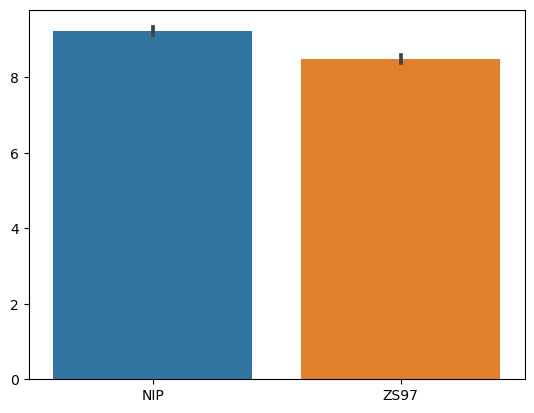

In [284]:
sns.barplot(zs_loss)
mannwhitneyu(zs_loss['NIP'], zs_loss['ZS97'])

MannwhitneyuResult(statistic=859062109.0, pvalue=2.0484140662082866e-100)

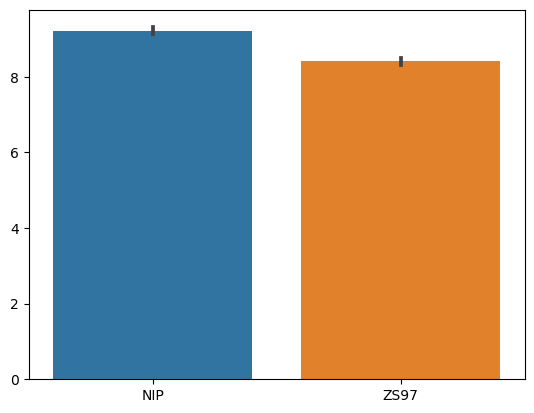

In [285]:
sns.barplot(zs_gain)
mannwhitneyu(zs_gain['NIP'], zs_gain['ZS97'])

MannwhitneyuResult(statistic=793733260.0, pvalue=6.6753353227800445e-77)

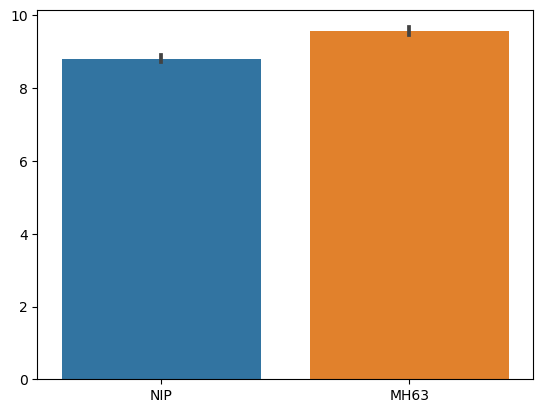

In [286]:
sns.barplot(mh_gain)
mannwhitneyu(mh_gain['NIP'], mh_gain['MH63'])

MannwhitneyuResult(statistic=781874722.5, pvalue=7.546895866879477e-79)

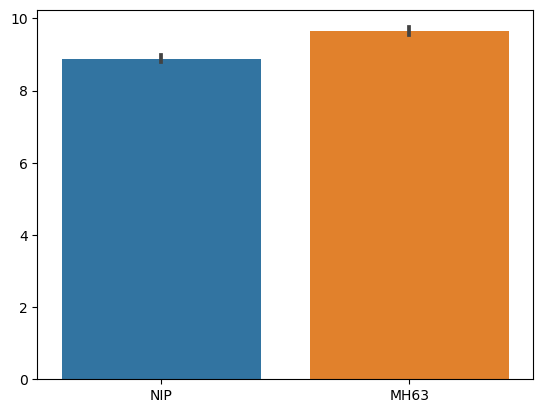

In [287]:
sns.barplot(mh_loss)
mannwhitneyu(mh_loss['NIP'], mh_loss['MH63'])